In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *
import graph_tool.all as gt

In [2]:
sns.set_context("talk")

In [3]:
ver = 630
fdir = "~/seungmount/research/runzhey/datasets/FlyWire/{}/syn_proof_analysis_ntavg_{}.feather".format(ver, ver)
# fdir = "/mnt/cup/labs/seung/research/runzhey/datasets/FlyWire/{}/syn_proof_analysis_{}.feather".format(ver, ver)
syn_table = pd.read_feather(fdir)

In [4]:
def vis_link(segs, mode='single'):
    if mode == 'single':
        with open("./saved/ng_templates/single_module_view.txt") as f:
            ng_tmp = f.read()
        return ng_tmp.format("%22%2C%22".join([str(seg) for seg in segs]))
    elif mode == 'double':
        with open("./saved/ng_templates/two_module_view.txt") as f:
            ng_tmp = f.read()
        return ng_tmp.format("%22%2C%22".join([str(seg) for seg in segs[0]]),
                             "%22%2C%22".join([str(seg) for seg in segs[1]]))
    return None

### 1. Graph Construction

In [5]:
# build index dictionary
cellids =  np.unique(syn_table[["pre_pt_root_id", "post_pt_root_id"]])
nid2cid = {i: cid for i, cid in enumerate(cellids)}
cid2nid = {cid: i for i, cid in enumerate(cellids)}

In [6]:
syn_table["pre_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["pre_pt_root_id"]], 
                                 index=syn_table.index)
syn_table["post_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["post_pt_root_id"]], 
                                 index=syn_table.index)

In [7]:
for nt_n in ["gaba_avg", "ach_avg", "glut_avg", "oct_avg", "ser_avg", "da_avg"]:
    syn_table[nt_n[:-4]+"_sum"] = syn_table[nt_n] * syn_table["syn_count"]

In [8]:
merged_syn_table = syn_table[["pre_nid", "post_nid", "syn_count", 
                              "gaba_sum", "ach_sum", "glut_sum", "oct_sum", "ser_sum", "da_sum"]
                             ].groupby(by=["pre_nid", "post_nid"]).sum().reset_index()
merged_syn_table["nt_type"] = merged_syn_table[["gaba_sum", "ach_sum", "glut_sum", 
                                                "oct_sum", "ser_sum", "da_sum"]].idxmax(axis="columns")

In [9]:
ntid2nt = ["gaba_sum", "ach_sum", "glut_sum", "oct_sum", "ser_sum", "da_sum"]
nt_colors = ["#D5A848", "#95A3CE", "#86A859", "#725C98", "#8C6295", "#B87969"]
nt2ntid = {nt: i for i, nt in enumerate(ntid2nt)}

In [10]:
merged_syn_table["nt_type_id"] = np.array([nt2ntid[nt] for nt in merged_syn_table.nt_type])

In [11]:
merged_edge_list = [(e[0], e[1], e[2], e[10]) for e in merged_syn_table.values]

In [12]:
g = gt.Graph()
g.add_vertex(len(cellids))
e_syn_count = g.new_ep("int32_t")
e_nt_type = g.new_ep("int32_t")
g.add_edge_list(merged_edge_list, eprops=[e_syn_count, e_nt_type])
g.vp["cellid"] = g.new_vp("int64_t")
g.vp["cellid"].a = cellids
g.ep["syn_count"] = e_syn_count
g.ep["nt_type"] = e_nt_type

In [13]:
# merged weightedd graph
g

<Graph object, directed, with 127319 vertices and 14680950 edges, 1 internal vertex property, 2 internal edge properties, at 0x7f0251da9fd0>

### 2-Cell Motif Strength and Type in the Whole Brain (w/ threshold)

In [14]:
%%time
strong_filter = g.new_ep('bool')
for e in g.edges():
    strong_filter[e] = True if g.ep["syn_count"][e] >=5 else False

CPU times: user 2min 16s, sys: 48 ms, total: 2min 16s
Wall time: 2min 16s


In [15]:
g.set_edge_filter(strong_filter)
g = gt.Graph(g, prune=True)
g

<Graph object, directed, with 127319 vertices and 2613129 edges, 1 internal vertex property, 2 internal edge properties, at 0x7f0251da90f0>

In [16]:
reciprocity = gt.edge_reciprocity(g)
print("edge reciprocity:", reciprocity)

edge reciprocity: 0.13837740119221056


In [17]:
# connection probability
p_conn = g.num_edges() / (g.num_vertices() * (g.num_vertices()-1))
print("connection probability:", p_conn)

connection probability: 0.00016120474575863678


In [18]:
edge_set = g.get_edges(eprops=[g.ep['syn_count'], g.ep['nt_type']])
edge_set_pairs = edge_set[:,:2]
edge_set_pairs = set((e[0], e[1]) for e in list(edge_set_pairs))

In [19]:
%%time
single_w = []
double_w = []
single_nt = []
double_nt = []

for e in edge_set:
    if (e[1], e[0]) in edge_set_pairs:
        double_w.append(e[2])
        double_nt.append(e[3])
    else:
        single_w.append(e[2])
        single_nt.append(e[3])

CPU times: user 2.04 s, sys: 20 ms, total: 2.06 s
Wall time: 2.05 s


In [20]:
np.mean(single_w), np.std(double_w)

(11.760731253533706, 28.075405750307986)

In [21]:
np.mean(single_w), np.std(double_w)

(11.760731253533706, 28.075405750307986)

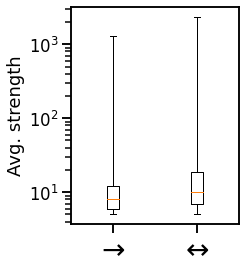

In [22]:
fig, ax = plt.subplots(1,1,figsize=(3,4))
ax.boxplot([single_w, double_w], whis=1000)
ax.set_xticks(range(1,3))
ax.xaxis.set_ticklabels(["→", "↔"], fontsize=28)
ax.set_yscale('log')
ax.set_ylabel('Avg. strength')
plt.savefig('figures/stats-{}/bi-strength.pdf'.format(ver), bbox_inches='tight')

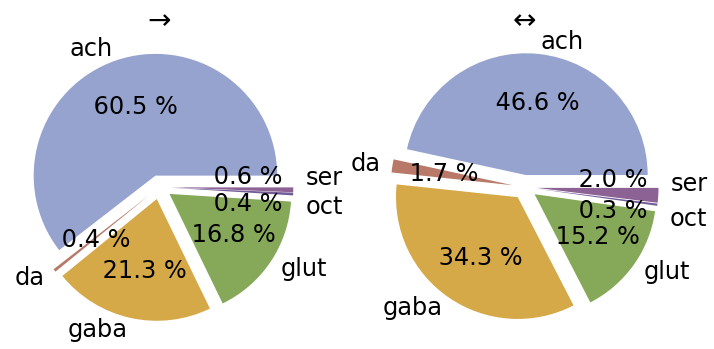

In [163]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
single_nt_names, single_nt_counts = np.unique([ntid2nt[i] for i in single_nt], return_counts=True)
double_nt_names, double_nt_counts = np.unique([ntid2nt[i] for i in double_nt], return_counts=True)
patches, texts, autotexts = axs[0].pie(single_nt_counts, 
       explode=[0.1]*6,
       labels=[n[:-4] for n in single_nt_names], 
       colors=[nt_colors[nt2ntid[n]] for n in single_nt_names],
       autopct ='% 1.1f %%')
texts[4]._y -= 0.1
texts[5]._y += 0.1
autotexts[4]._y -= 0.1
autotexts[5]._y += 0.1
axs[0].set_title("→", fontsize=28)

for label in axs[0].texts:
    label.set_fontsize(24)

patches, texts, autotexts = axs[1].pie(double_nt_counts, 
       explode=[0.1]*6,
       labels=[n[:-4] for n in double_nt_names], 
       colors=[nt_colors[nt2ntid[n]] for n in double_nt_names],
       autopct ='% 1.1f %%')
texts[4]._y -= 0.1
texts[5]._y += 0.1
autotexts[4]._y -= 0.1
autotexts[5]._y += 0.1
axs[1].set_title("↔", fontsize=28)

for label in axs[1].texts:
    label.set_fontsize(24)

plt.savefig('figures/stats-{}/bi-nt-type.pdf'.format(ver), bbox_inches='tight')

In [30]:
%%time 

bi_edge_nt = {}

for e1 in g.edges():
    for e2 in g.get_out_edges(e1.target(), eprops=[g.ep['nt_type']]):
        if e2[1] == e1.source():
            nt1 = ntid2nt[g.ep['nt_type'][e1]][:-4]
            nt2 = ntid2nt[e2[2]][:-4]
            if nt1 < nt2:
                nt_pair = nt1 + "-" + nt2
            else:
                nt_pair = nt2 + "-" + nt1
            
            if nt_pair in bi_edge_nt.keys():
                bi_edge_nt[nt_pair] += 1
            else:
                bi_edge_nt[nt_pair] =1

CPU times: user 37min 35s, sys: 96 ms, total: 37min 35s
Wall time: 37min 35s


In [31]:
import pickle
with open('saved/bi-ny-type.pickle', 'wb') as handle:
    pickle.dump(bi_edge_nt, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('saved/bi-ny-type.pickle', 'rb') as handle:    
#     bi_edge_nt = pickle.load(handle)

In [32]:
bi_nt_order = np.argsort(list(bi_edge_nt.values()))[::-1]

In [33]:
np.array(list(bi_edge_nt.keys()))[bi_nt_order]

array(['ach-gaba', 'ach-glut', 'ach-ach', 'gaba-glut', 'gaba-gaba',
       'glut-glut', 'ach-ser', 'ach-da', 'ser-ser', 'gaba-ser', 'da-gaba',
       'da-glut', 'da-da', 'glut-ser', 'ach-oct', 'da-ser', 'gaba-oct',
       'glut-oct', 'oct-ser', 'da-oct', 'oct-oct'], dtype='<U9')

In [34]:
from matplotlib import rc
rc('text',usetex=False)

In [35]:
def partial_color_labels(label, seperator="-"):
    new_str = ""
    for x in label.split(seperator):
        if len(new_str) > 0:
            new_str = new_str + seperator
#         new_str = new_str + r'\textcolor{'+nt_colors[nt2ntid[x+"_sum"]]+'}{'+x+"}"
        new_str = new_str + r'\textcolor{'+"yellow"+'}{'+x+"}"
    return new_str

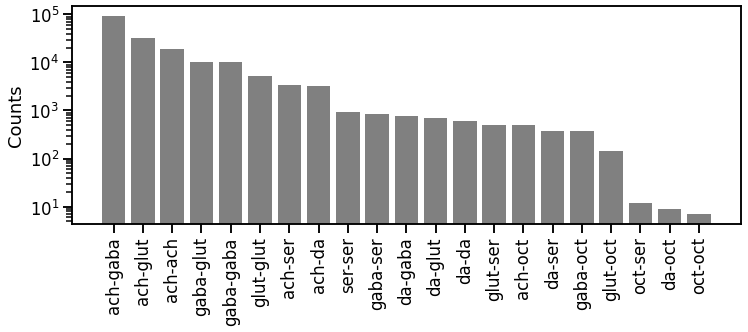

In [36]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(bi_edge_nt.keys()))[bi_nt_order], 
       np.array(list(bi_edge_nt.values()))[bi_nt_order]/2,
       color='gray')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Counts')
ax.set_yscale('log')
# plt.savefig('figures/stats-{}/bi-re-nt-type.pdf'.format(ver), bbox_inches='tight')

In [37]:
bi_edge_nt_marginal = {n: cnt/sum(double_nt_counts) for n, cnt in zip([n[:-4] for n in double_nt_names], double_nt_counts)}

In [38]:
bi_edge_nt_independent = {}
for n1 in bi_edge_nt_marginal.keys():
    for n2 in bi_edge_nt_marginal.keys():
        if n1 <= n2:
            bi_edge_nt_independent[n1 + "-" + n2] = bi_edge_nt_marginal[n1] * bi_edge_nt_marginal[n2]

In [39]:
bi_edge_nt_percent = {n: bi_edge_nt[n] / sum(bi_edge_nt.values()) for n in bi_edge_nt.keys()}

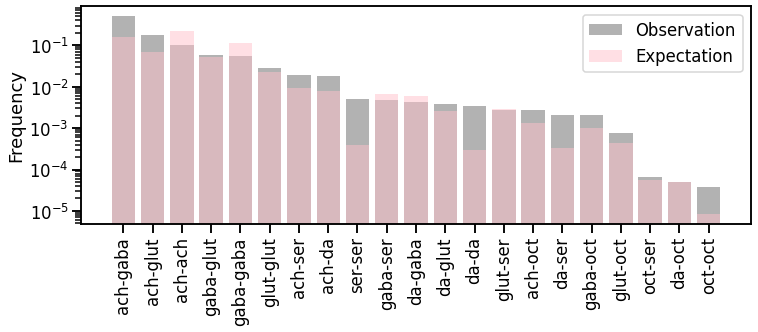

In [40]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(bi_edge_nt_percent.keys()))[bi_nt_order], 
       np.array(list(bi_edge_nt_percent.values()))[bi_nt_order],
       color='gray', alpha=0.6, label="Observation")
ax.bar(np.array(list(bi_edge_nt_independent.keys()))[bi_nt_order], 
       np.array(list(bi_edge_nt_independent.values()))[bi_nt_order],
       color='pink', alpha=0.5, label="Expectation")
# ax.set_xticks(range(1,3))
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.legend()
plt.savefig('figures/stats-{}/bi-re-nt-type-percent.pdf'.format(ver), bbox_inches='tight')

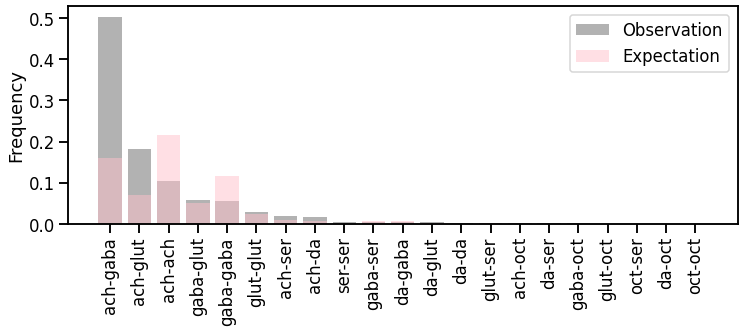

In [41]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(bi_edge_nt_percent.keys()))[bi_nt_order], 
       np.array(list(bi_edge_nt_percent.values()))[bi_nt_order],
       color='gray', alpha=0.6, label="Observation")
ax.bar(np.array(list(bi_edge_nt_independent.keys()))[bi_nt_order], 
       np.array(list(bi_edge_nt_independent.values()))[bi_nt_order],
       color='pink', alpha=0.5, label="Expectation")
# ax.set_xticks(range(1,3))
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Frequency')
# ax.set_yscale('log')
ax.legend()
plt.savefig('figures/stats-{}/bi-re-nt-type-percent-normscale.pdf'.format(ver), bbox_inches='tight')

In [42]:
bi_edge_nt_percent['ach-gaba'], bi_edge_nt_percent['ach-gaba'] / bi_edge_nt_independent['ach-gaba']

(0.5031443757985387, 3.1527637351124618)

In [43]:
bi_edge_nt_percent['ach-glut'] / bi_edge_nt_independent['ach-glut']

2.5658348687723076

In [44]:
bi_edge_nt_percent['ach-ach'] / bi_edge_nt_independent['ach-ach']

0.4778191268300984

### 2-Cell Motif Strength and Type in the Neuropils (w/ threshold)

In [201]:
np_order = ["FB","EB","PB","NO","AMMC_L","AMMC_R","FLA_L","FLA_R","CAN_L","CAN_R","PRW","SAD","GNG","AL_L","AL_R","LH_L","LH_R","MB_CA_L","MB_CA_R","MB_PED_L","MB_PED_R","MB_VL_L","MB_VL_R","MB_ML_L","MB_ML_R","BU_L","BU_R","GA_L","GA_R","LAL_L","LAL_R","SLP_L","SLP_R","SIP_L","SIP_R","SMP_L","SMP_R","CRE_L","CRE_R","SCL_L","SCL_R","ICL_L","ICL_R","IB_L","IB_R","ATL_L","ATL_R","VES_L","VES_R","EPA_L","EPA_R","GOR_L","GOR_R","SPS_L","SPS_R","IPS_L","IPS_R","AOTU_L","AOTU_R","AVLP_L","AVLP_R","PVLP_L","PVLP_R","PLP_L","PLP_R","WED_L","WED_R","ME_L","ME_R","AME_L","AME_R","LO_L","LO_R","LOP_L","LOP_R","LA_L","LA_R","OCG"]
np_names = ["FB","EB","PB","NO","AMMC(R)","AMMC(L)","FLA(R)","FLA(L)","CAN(R)","CAN(L)","PRW","SAD","GNG","AL(R)","AL(L)","LH(R)","LH(L)","MB-CA(R)","MB-CA(L)","MB-PED(R)","MB-PED(L)","MB-VL(R)","MB-VL(L)","MB-ML(R)","MB-ML(L)","BU(R)","BU(L)","GA(R)","GA(L)","LAL(R)","LAL(L)","SLP(R)","SLP(L)","SIP(R)","SIP(L)","SMP(R)","SMP(L)","CRE(R)","CRE(L)","SCL(R)","SCL(L)","ICL(R)","ICL(L)","IB(R)","IB(L)","ATL(R)","ATL(L)","VES(R)","VES(L)","EPA(R)","EPA(L)","GOR(R)","GOR(L)","SPS(R)","SPS(L)","IPS(R)","IPS(L)","AOTU(R)","AOTU(L)","AVLP(R)","AVLP(L)","PVLP(R)","PVLP(L)","PLP(R)","PLP(L)","WED(R)","WED(L)","ME(R)","ME(L)","AME(R)","AME(L)","LO(R)","LO(L)","LOP(R)","LOP(L)","LA(R)","LA(L)","OCG"]
np_color = ["#049a93","#10cac8","#36cfdc","#21adc4","#145ddc","#145ddc","#274bfe","#274bfe","#2081f2","#2081f2","#513bfe","#513bfe","#603ee4","#30d2fe","#30d2fe","#fe99b8","#fe99b8","#fe9e3f","#fe9e3f","#ffa88d","#ffa88d","#ffae79","#ffae79","#ff9e69","#ff9e69","#5479ef","#5479ef","#3d8ce2","#3d8ce2","#285bfa","#285bfa","#fed942","#fed942","#feb13a","#feb13a","#ffda59","#ffda59","#febd3b","#febd3b","#fdb95d","#fdb95d","#fbb256","#fbb256","#fe9e3e","#fe9e3e","#fead49","#fead49","#02dcc0","#02dcc0","#07c4ac","#07c4ac","#00b5d3","#00b5d3","#00957e","#00957e","#0dbfc2","#0dbfc2","#4c9efe","#4c9efe","#3d89fe","#3d89fe","#1a57ee","#1a57ee","#50bcfe","#50bcfe","#3b8dfe","#3b8dfe","#dd41d3","#dd41d3","#bc21a2","#bc21a2","#8a34d4","#8a34d4","#bc21a2","#bc21a2","#A21A78","#A21A78","#EA4BEA"]

In [46]:
%%time
import warnings
warnings.filterwarnings('ignore')

g_np = {}
for np_n in np_order:
    syn_table_np = syn_table[syn_table.neuropil == np_n]
    cellids_np =  np.unique(syn_table_np[["pre_pt_root_id", "post_pt_root_id"]])
    nid2cid_np = {i: cid for i, cid in enumerate(cellids_np)}
    cid2nid_np = {cid: i for i, cid in enumerate(cellids_np)}
    syn_table_np["pre_nid_np"] = pd.Series([cid2nid_np[cid] for cid in syn_table_np["pre_pt_root_id"]], 
                                 index=syn_table_np.index)
    syn_table_np["post_nid_np"] = pd.Series([cid2nid_np[cid] for cid in syn_table_np["post_pt_root_id"]], 
                                     index=syn_table_np.index)
    merged_syn_table_np = syn_table_np[["pre_nid_np", "post_nid_np", "syn_count", 
                              "gaba_sum", "ach_sum", "glut_sum", "oct_sum", "ser_sum", "da_sum"]
                             ].groupby(by=["pre_nid_np", "post_nid_np"]).sum().reset_index()
    merged_syn_table_np["nt_type"] = merged_syn_table_np[["gaba_sum", "ach_sum", "glut_sum", 
                                                          "oct_sum", "ser_sum", "da_sum"]].idxmax(axis="columns")
    merged_syn_table_np["nt_type_id"] = np.array([nt2ntid[nt] for nt in merged_syn_table_np.nt_type])
    merged_edge_list_np = [(e[0], e[1], e[2], e[10]) for e in merged_syn_table_np.values]
    g_np[np_n] = gt.Graph()
    g_np[np_n].add_vertex(len(cellids_np))
    e_syn_count_np = g_np[np_n].new_ep("int32_t")
    e_nt_type_np = g_np[np_n].new_ep("int32_t")
    g_np[np_n].add_edge_list(merged_edge_list_np, eprops=[e_syn_count_np, e_nt_type_np])
    g_np[np_n].vp["cellid"] = g_np[np_n].new_vp("int64_t")
    g_np[np_n].vp["cellid"].a = cellids_np
    g_np[np_n].ep["syn_count"] = e_syn_count_np
    g_np[np_n].ep["nt_type"] = e_nt_type_np

CPU times: user 2min 26s, sys: 4.94 s, total: 2min 31s
Wall time: 2min 32s


In [47]:
%%time
for np_n in g_np.keys():
    strong_filter = g_np[np_n].new_ep('bool')
    for e in g_np[np_n].edges():
        strong_filter[e] = True if g_np[np_n].ep["syn_count"][e] >=5 else False
    g_np[np_n].set_edge_filter(strong_filter)
    g_np[np_n] = gt.Graph(g_np[np_n], prune=True)

CPU times: user 2min 42s, sys: 544 ms, total: 2min 42s
Wall time: 2min 32s


In [48]:
rec_np = {}
p_conn_np = {}
for np_n in g_np.keys():
    rec_np[np_n] = gt.edge_reciprocity(g_np[np_n])
    p_conn_np[np_n] = g_np[np_n].num_edges() / (g_np[np_n].num_vertices() * (g_np[np_n].num_vertices()-1))

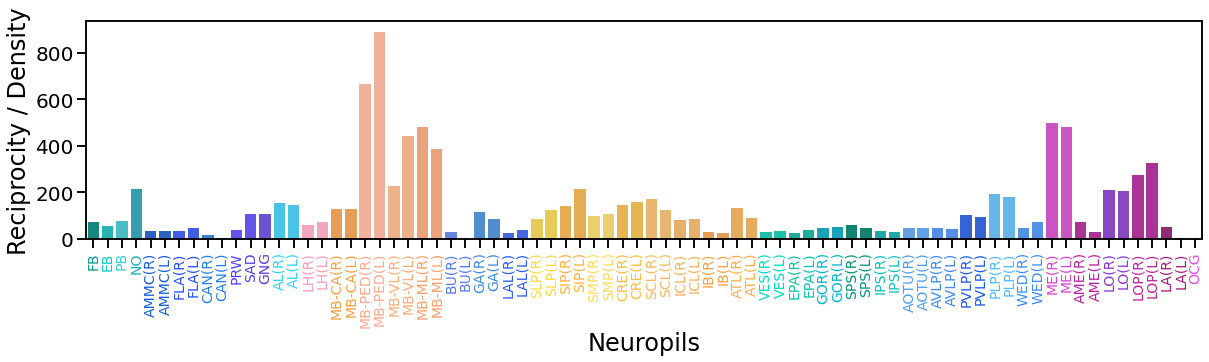

In [202]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, y=[rec_np[np_n] / p_conn_np[np_n] for np_n in np_order], palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
# ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Reciprocity / Density", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/neuropil-reciprocal.pdf'.format(ver), bbox_inches='tight')

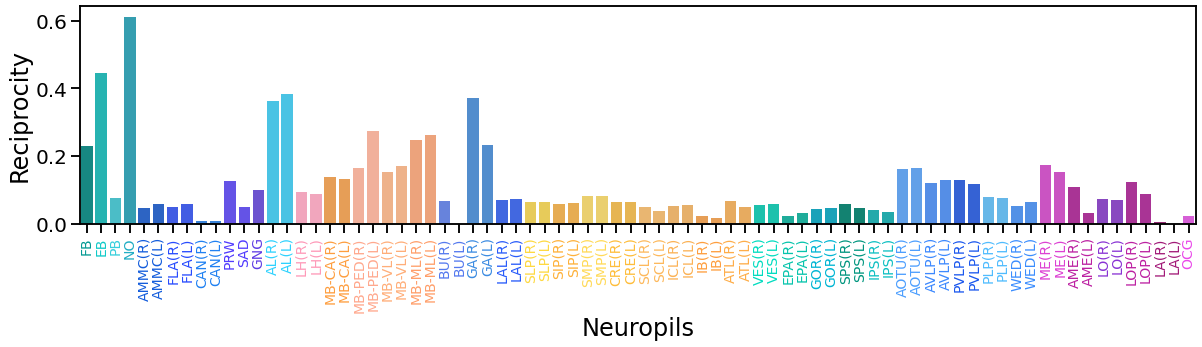

In [280]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, y=[rec_np[np_n] for np_n in np_order], palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
# ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Reciprocity", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/neuropil-reciprocal-abs.pdf'.format(ver), bbox_inches='tight')

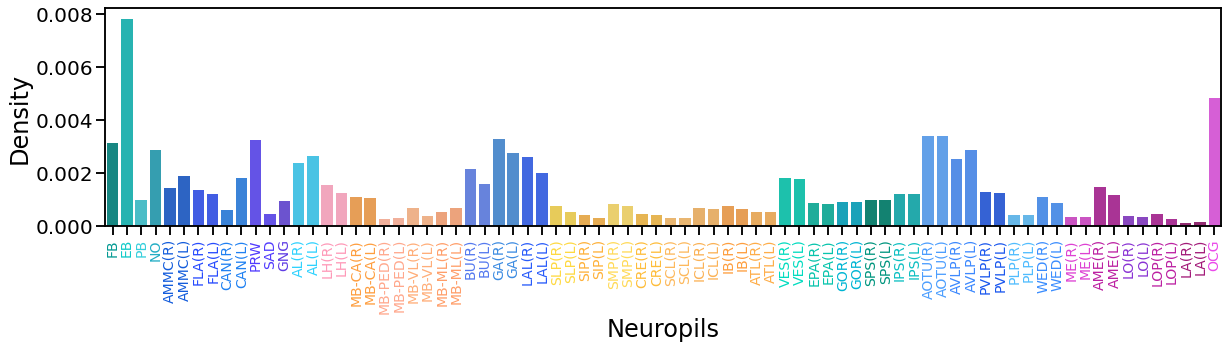

In [281]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, y=[p_conn_np[np_n] for np_n in np_order], palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
# ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Density", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/neuropil-density.pdf'.format(ver), bbox_inches='tight')

In [51]:
%%time

single_w_np = {}
double_w_np = {}
single_nt_np = {}
double_nt_np = {}

for np_n in np_order:
    
    single_w_np[np_n] = []
    double_w_np[np_n] = []
    single_nt_np[np_n] = []
    double_nt_np[np_n] = []

    edge_set_np = g_np[np_n].get_edges(eprops=[g_np[np_n].ep['syn_count'], g_np[np_n].ep['nt_type']])
    edge_set_pairs_np = edge_set_np[:,:2]
    edge_set_pairs_np = set((e[0], e[1]) for e in list(edge_set_pairs_np))

    for e in edge_set_np:
        if (e[1], e[0]) in edge_set_pairs_np:
            double_w_np[np_n].append(e[2])
            double_nt_np[np_n].append(e[3])
        else:
            single_w_np[np_n].append(e[2])
            single_nt_np[np_n].append(e[3])

CPU times: user 3.89 s, sys: 52 ms, total: 3.94 s
Wall time: 3.94 s


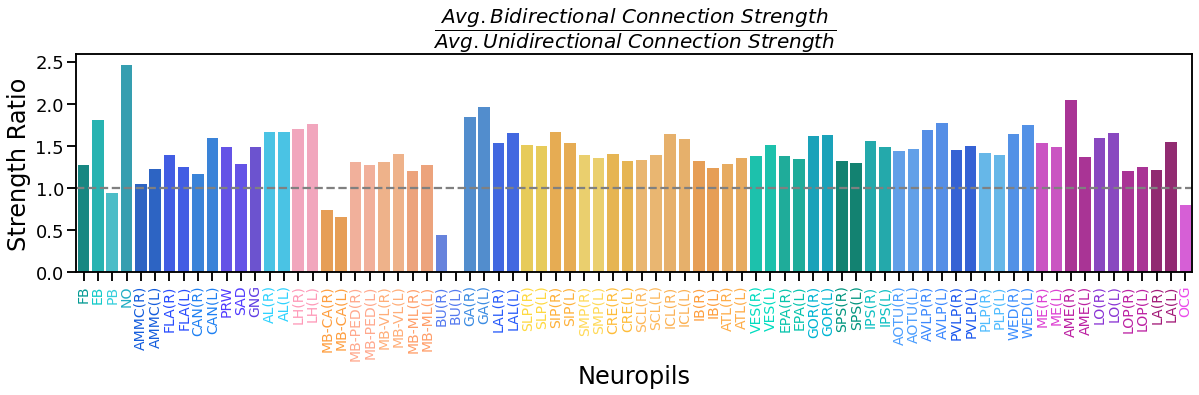

In [204]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=[np.mean(double_w_np[np_n]) / np.mean(single_w_np[np_n]) for np_n in np_order],
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.tick_params(axis='y', labelsize=18)    
ax.axhline(1.0, color='gray', linestyle='--')
ax.set_title("$\dfrac{Avg. Bidirectional~ Connection~ Strength}{Avg. Unidirectional~ Connection~ Strength}$", fontsize=20)
ax.set_ylabel("Strength Ratio", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/bi-strength-np.pdf'.format(ver), bbox_inches='tight')

In [53]:
uni_edge_nt_marginal_np = {}
bi_edge_nt_marginal_np = {}
for np_n in np_order:
    single_nt_names_np, single_nt_counts_np = np.unique(single_nt_np[np_n], return_counts=True)
    uni_edge_nt_marginal_np[np_n] = {n: cnt/sum(single_nt_counts_np) 
                                 for n, cnt in zip([ntid2nt[n][:-4] for n in single_nt_names_np], single_nt_counts_np)}
    double_nt_names_np, double_nt_counts_np = np.unique(double_nt_np[np_n], return_counts=True)
    bi_edge_nt_marginal_np[np_n] = {n: cnt/sum(double_nt_counts_np) 
                                 for n, cnt in zip([ntid2nt[n][:-4] for n in double_nt_names_np], double_nt_counts_np)}

In [54]:
for np_n in np_order:
    for n in ntid2nt:
        n = n[:-4]
        if not n in bi_edge_nt_marginal_np[np_n].keys():
            bi_edge_nt_marginal_np[np_n][n] = 0
        if not n in uni_edge_nt_marginal_np[np_n].keys():
            uni_edge_nt_marginal_np[np_n][n] = 0

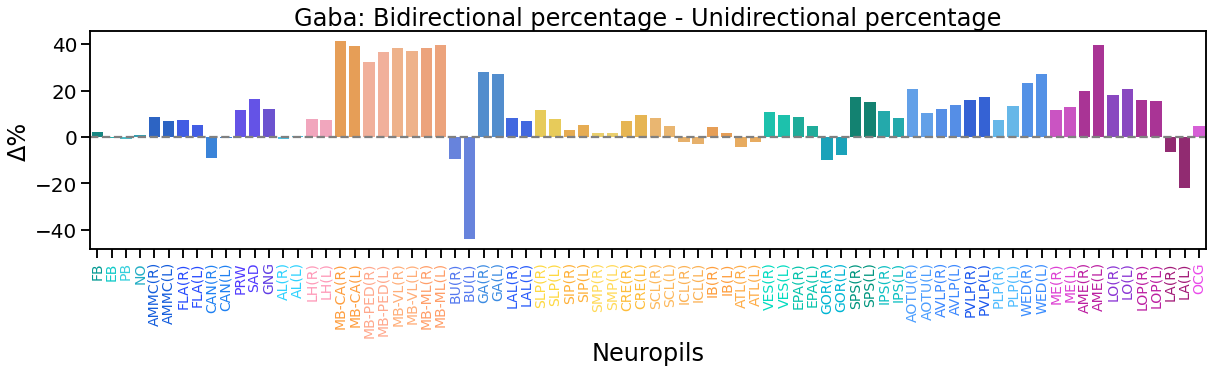

In [282]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['gaba'] - uni_edge_nt_marginal_np[np_n]['gaba'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Gaba: Bidirectional percentage - Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Δ%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/gaba-precentage-np.pdf'.format(ver), bbox_inches='tight')

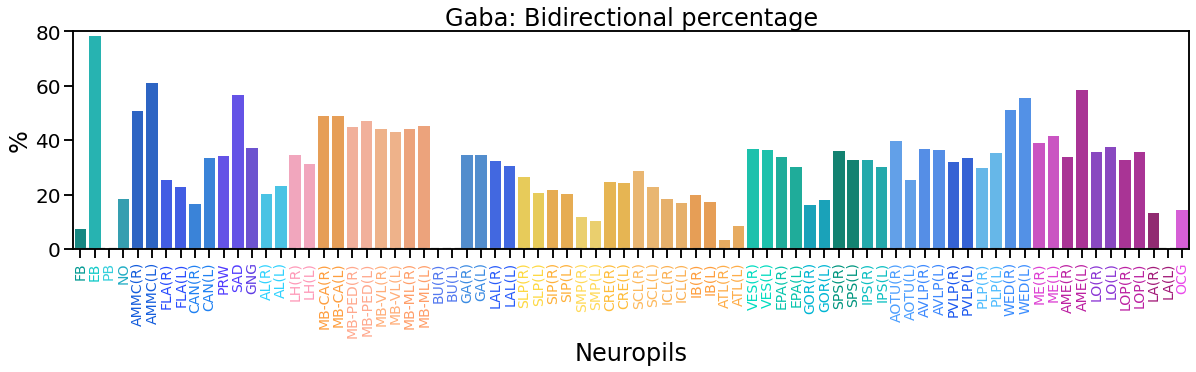

In [285]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['gaba'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Gaba: Bidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,80])
plt.savefig('figures/stats-{}/gaba-precentage-np-bi-absolute.pdf'.format(ver), bbox_inches='tight')

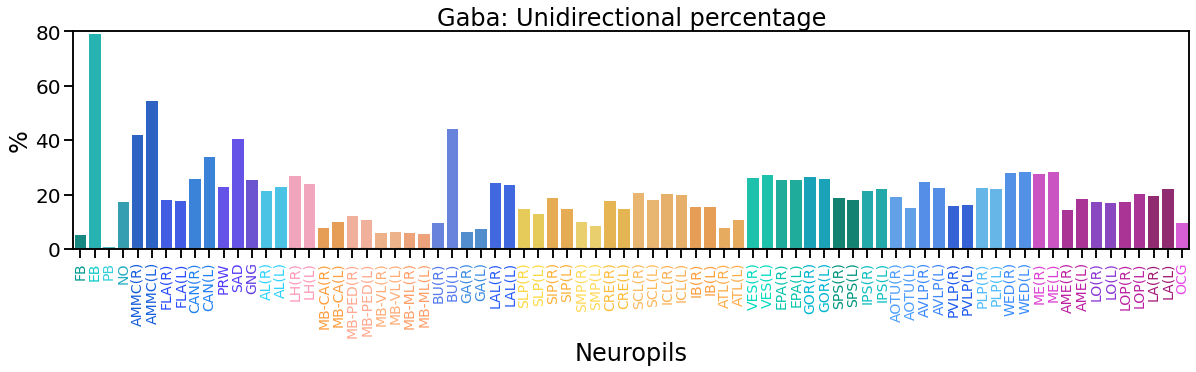

In [286]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([uni_edge_nt_marginal_np[np_n]['gaba'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Gaba: Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,80])
plt.savefig('figures/stats-{}/gaba-precentage-np-uni-absolute.pdf'.format(ver), bbox_inches='tight')

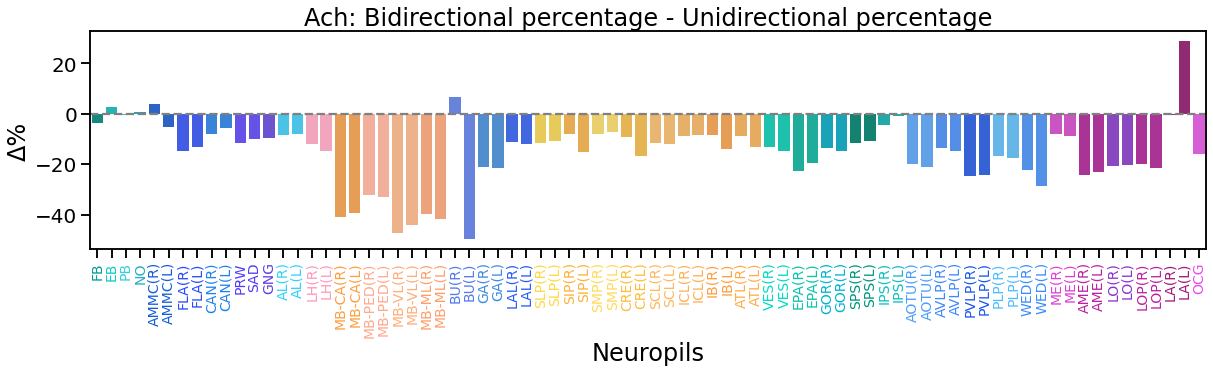

In [287]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['ach'] - uni_edge_nt_marginal_np[np_n]['ach'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Ach: Bidirectional percentage - Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Δ%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/ach-precentage-np.pdf'.format(ver), bbox_inches='tight')

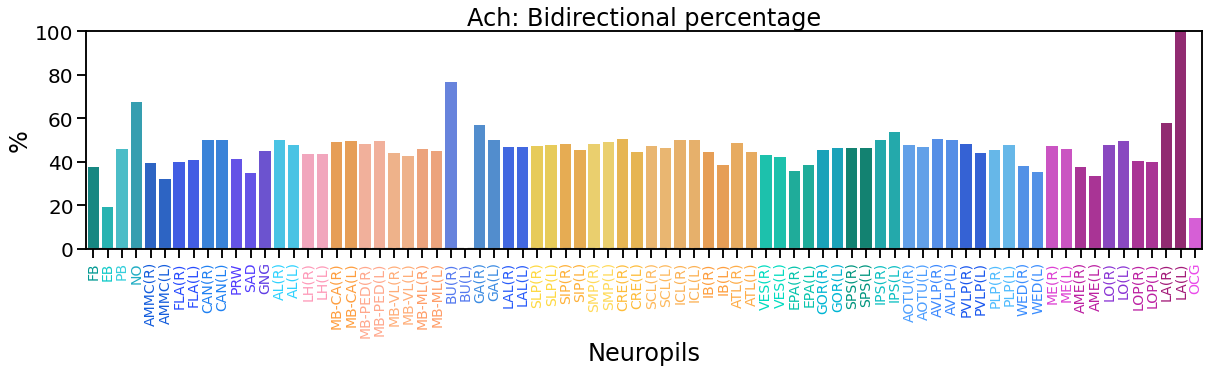

In [290]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['ach'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Ach: Bidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,100])
plt.savefig('figures/stats-{}/ach-precentage-np-bi-absolute.pdf'.format(ver), bbox_inches='tight')

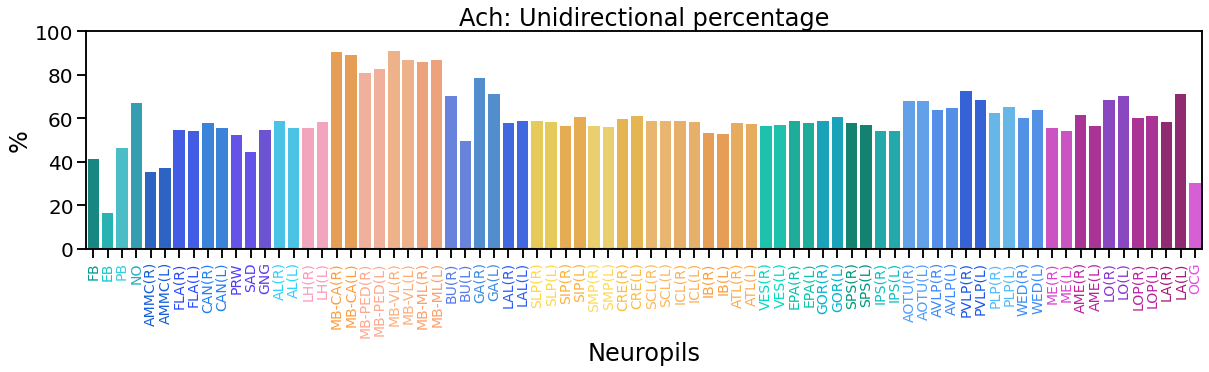

In [289]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([uni_edge_nt_marginal_np[np_n]['ach'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Ach: Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,100])
plt.savefig('figures/stats-{}/ach-precentage-np-uni-absolute.pdf'.format(ver), bbox_inches='tight')

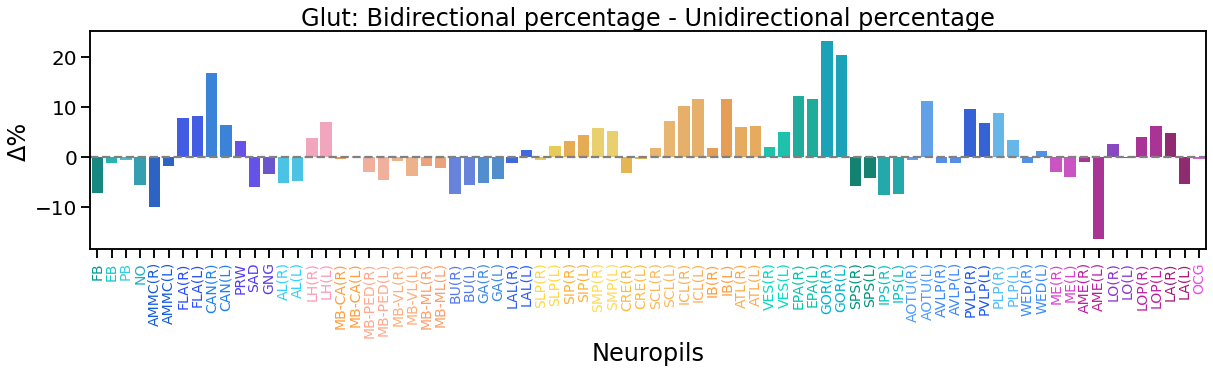

In [291]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['glut'] - uni_edge_nt_marginal_np[np_n]['glut'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Glut: Bidirectional percentage - Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Δ%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/glut-precentage-np.pdf'.format(ver), bbox_inches='tight')

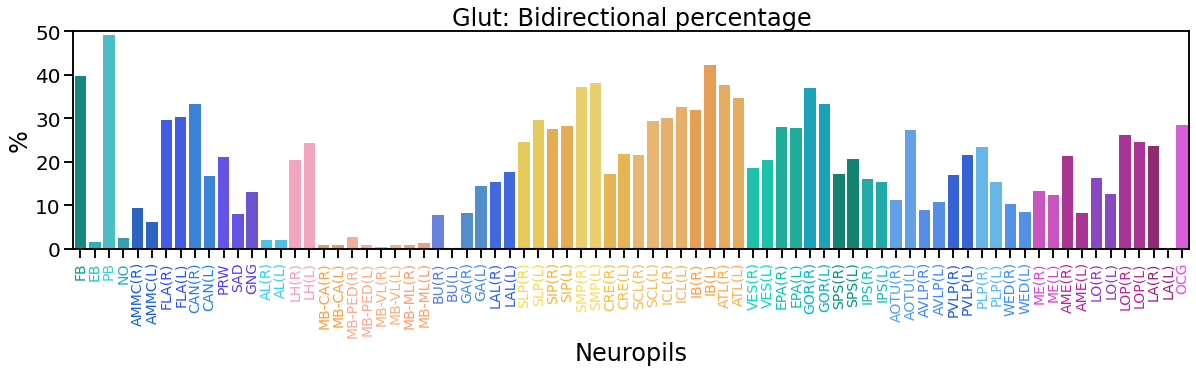

In [292]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['glut'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Glut: Bidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,50])
plt.savefig('figures/stats-{}/glut-precentage-np-bi-absolute.pdf'.format(ver), bbox_inches='tight')

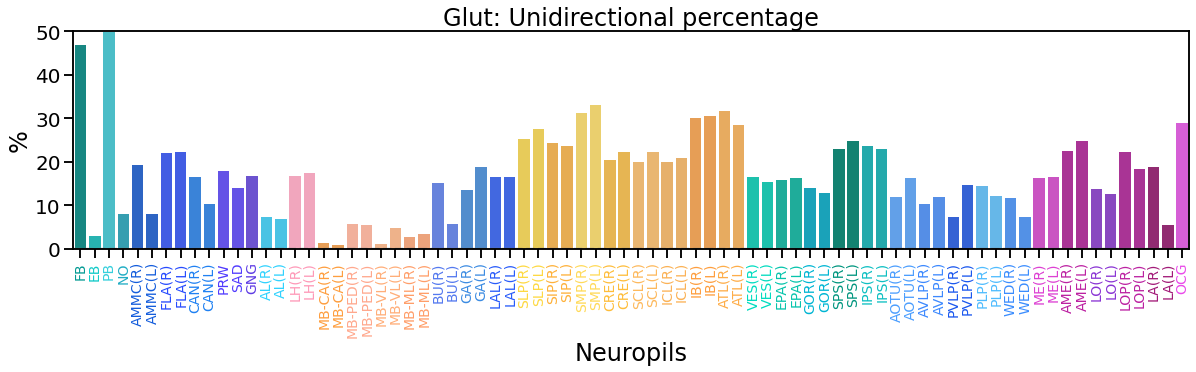

In [293]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([uni_edge_nt_marginal_np[np_n]['glut'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Glut: Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,50])
plt.savefig('figures/stats-{}/glut-precentage-np-uni-absolute.pdf'.format(ver), bbox_inches='tight')

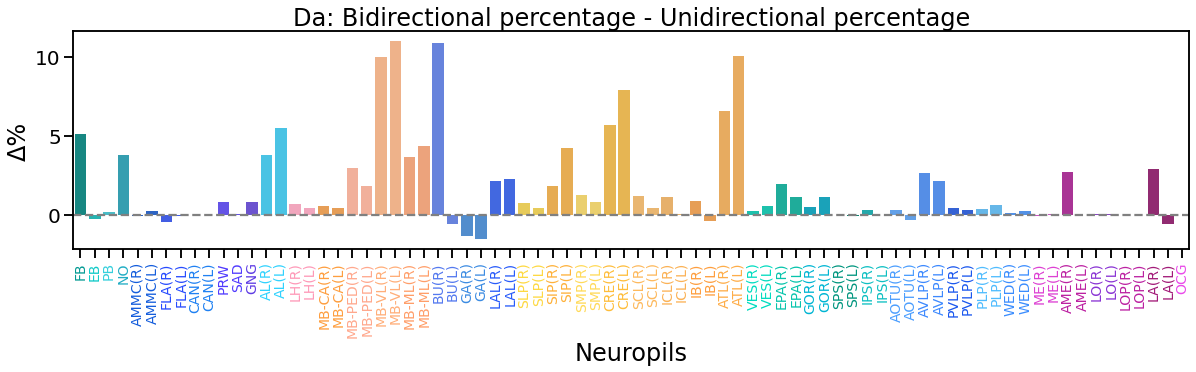

In [294]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['da'] - uni_edge_nt_marginal_np[np_n]['da'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Da: Bidirectional percentage - Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Δ%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/da-precentage-np.pdf'.format(ver), bbox_inches='tight')

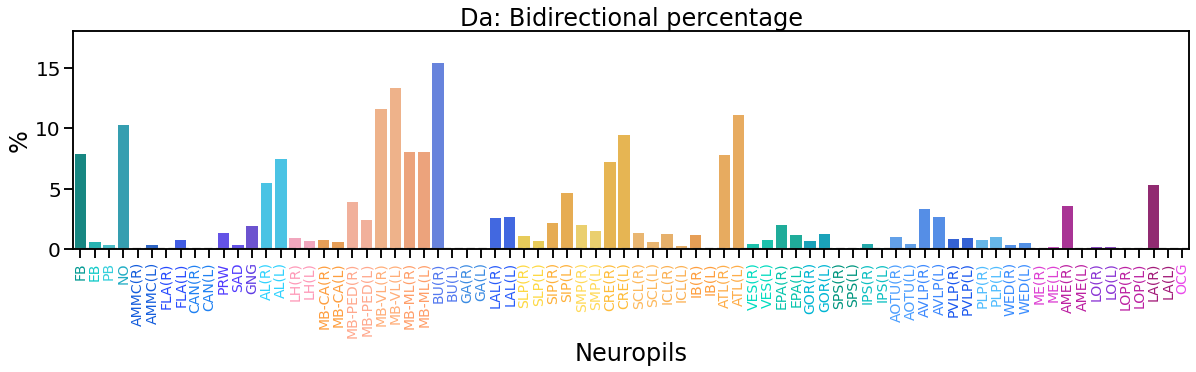

In [295]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['da'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Da: Bidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,18])
plt.savefig('figures/stats-{}/da-precentage-np-bi-absolute.pdf'.format(ver), bbox_inches='tight')

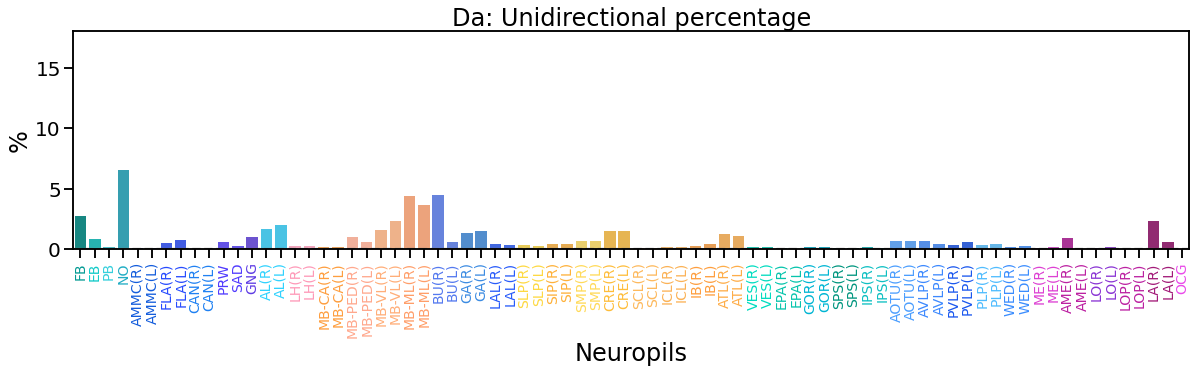

In [296]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([uni_edge_nt_marginal_np[np_n]['da'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Da: Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,18])
plt.savefig('figures/stats-{}/da-precentage-np-uni-absolute.pdf'.format(ver), bbox_inches='tight')

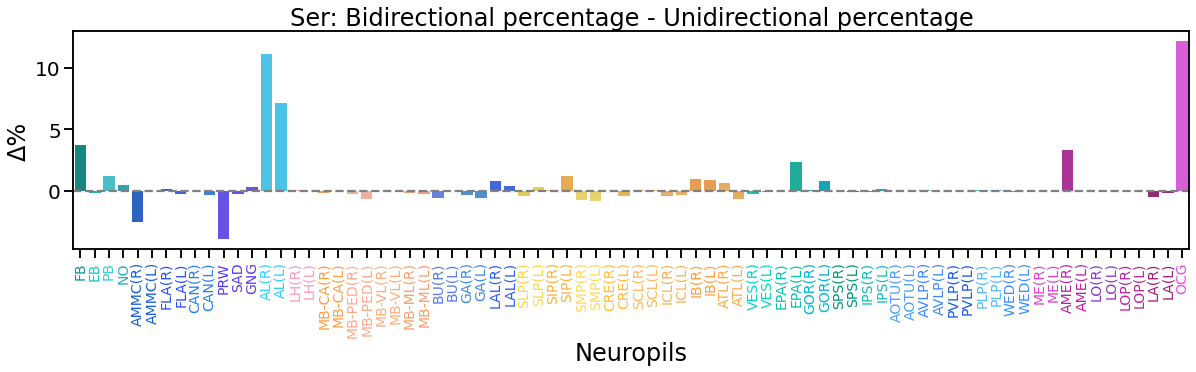

In [297]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['ser'] - uni_edge_nt_marginal_np[np_n]['ser'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Ser: Bidirectional percentage - Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Δ%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/ser-precentage-np.pdf'.format(ver), bbox_inches='tight')

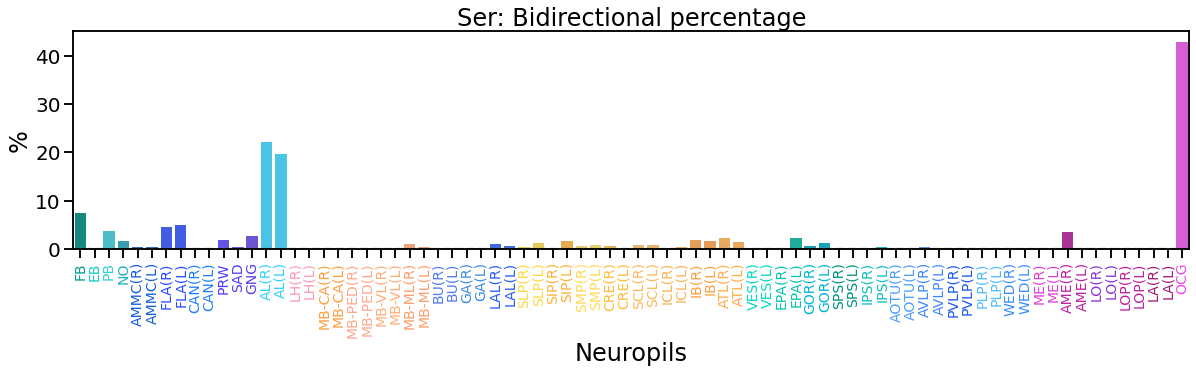

In [298]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['ser'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Ser: Bidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,45])
plt.savefig('figures/stats-{}/ser-precentage-np-bi-absolute.pdf'.format(ver), bbox_inches='tight')

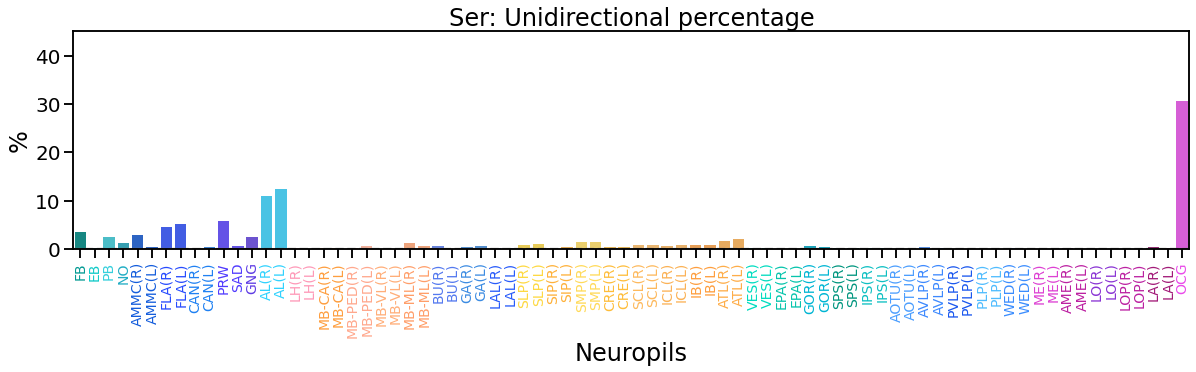

In [299]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([uni_edge_nt_marginal_np[np_n]['ser'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Ser: Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,45])
plt.savefig('figures/stats-{}/ser-precentage-np-uni-absolute.pdf'.format(ver), bbox_inches='tight')

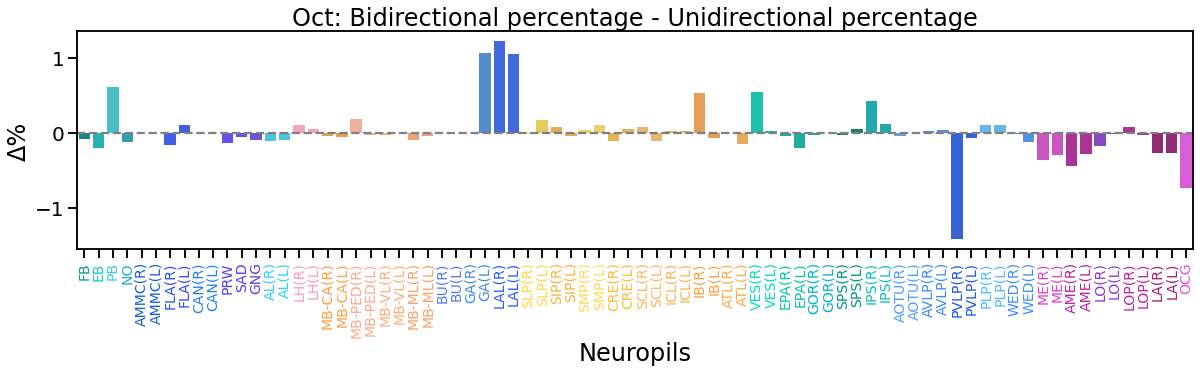

In [300]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['oct'] - uni_edge_nt_marginal_np[np_n]['oct'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Oct: Bidirectional percentage - Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Δ%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/oct-precentage-np.pdf'.format(ver), bbox_inches='tight')

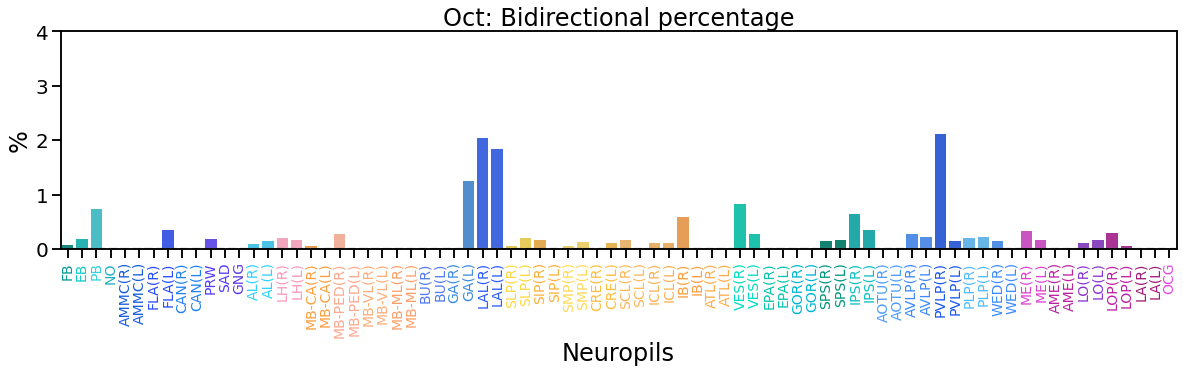

In [301]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([bi_edge_nt_marginal_np[np_n]['oct'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Oct: Bidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,4])
plt.savefig('figures/stats-{}/oct-precentage-np-bi-absolute.pdf'.format(ver), bbox_inches='tight')

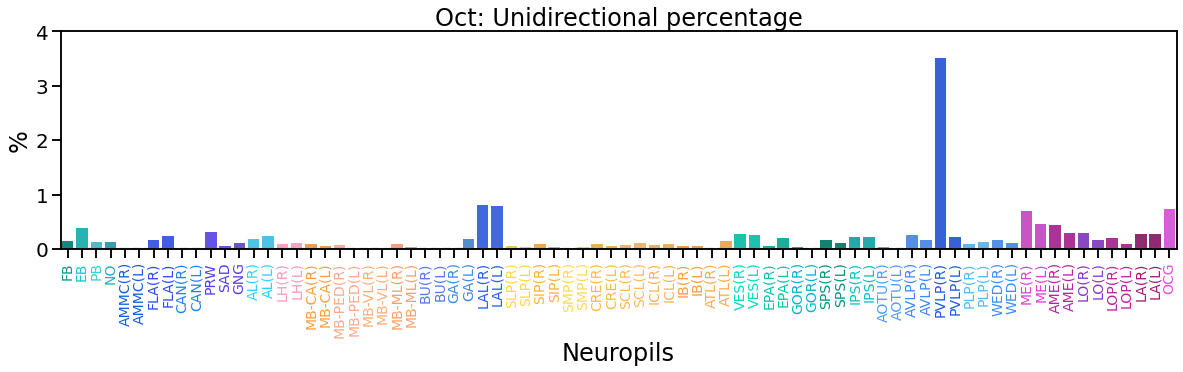

In [302]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=100*np.array([uni_edge_nt_marginal_np[np_n]['oct'] for np_n in np_order]),
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("Oct: Unidirectional percentage", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("%", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
ax.set_ylim([0,4])
plt.savefig('figures/stats-{}/oct-precentage-np-uni-absolute.pdf'.format(ver), bbox_inches='tight')

### Find Example 2-Cell Motifs

In [197]:
edge_set_strong_all = edge_set[(edge_set[:,2]>=5)]
edge_set_strong_ach = edge_set[(edge_set[:,2]>=5) & (edge_set[:,3]==1)]
edge_set_strong_gaba = edge_set[(edge_set[:,2]>=5) & (edge_set[:,3]==0)]
edge_set_strong_glut = edge_set[(edge_set[:,2]>=5) & (edge_set[:,3]==2)]

In [198]:
strong_all_pairs = set((e[0], e[1]) for e in list(edge_set_strong_all[:,:2]))
strong_ach_pairs = set((e[0], e[1]) for e in list(edge_set_strong_ach[:,:2]))
strong_gaba_pairs = set((e[0], e[1]) for e in list(edge_set_strong_gaba[:,:2]))
strong_glut_pairs = set((e[0], e[1]) for e in list(edge_set_strong_glut[:,:2]))

In [190]:
nt_all_strong_dict = {(e[0], e[1]):e[3] for e in list(edge_set_strong_all)}

In [195]:
strong_all_all = []
for e in strong_all_pairs:
    if (e[1], e[0]) in strong_all_pairs:
        if e[1] > e[0]:
            strong_all_all.append((nid2cid[e[0]], nid2cid[e[1]], 
                                   ntid2nt[(nt_all_strong_dict[(e[0], e[1])])][:-4],
                                   ntid2nt[(nt_all_strong_dict[(e[1], e[0])])][:-4]))

In [65]:
# strong_all_all

In [66]:
strong_ach_gaba = []
for e in strong_gaba_pairs:
    if (e[1], e[0]) in strong_ach_pairs:
        strong_ach_gaba.append((nid2cid[e[0]], nid2cid[e[1]]))

In [67]:
strong_ach_ach = []
for e in strong_ach_pairs:
    if (e[1], e[0]) in strong_ach_pairs:
        if e[1] > e[0]:
            strong_ach_ach.append((nid2cid[e[0]], nid2cid[e[1]]))

In [68]:
strong_ach_glut = []
for e in strong_glut_pairs:
    if (e[1], e[0]) in strong_ach_pairs:
        strong_ach_glut.append((nid2cid[e[0]], nid2cid[e[1]]))

In [199]:
len(strong_all_all) #, len(strong_ach_gaba), len(strong_ach_ach), len(strong_ach_glut)

180799

In [200]:
pd.DataFrame(np.array(strong_all_all), columns=['n1', 'n2','n1_nt', 'n2_nt']).to_csv(
    "saved/v630-all-reciprocal-pairs-s5.csv", index=False)

In [71]:
pd.DataFrame(np.array(strong_ach_gaba), columns=['gaba', 'ach']).to_csv(
    "saved/v630-all-gaba-ach-pairs.csv", index=False)

In [72]:
pd.DataFrame(np.array(strong_ach_glut), columns=['glut', 'ach']).to_csv(
    "saved/v630-all-glut-ach-pairs.csv", index=False)

In [73]:
pd.DataFrame(np.array(strong_ach_ach), columns=['ach-1', 'ach-2']).to_csv(
    "saved/v630-all-ach-ach-pairs.csv", index=False)

In [74]:
top_nid, npairs = np.unique(np.array(strong_all_all), return_counts=True)

Text(0.5, 0, 'rank')

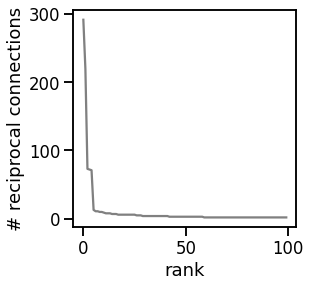

In [75]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(np.sort(npairs)[::-1][:100], color='gray')
ax.set_ylabel('# reciprocal connections')
ax.set_xlabel('rank')

In [76]:
# top_nid[np.argsort(npairs)[::-1][:100]]

In [77]:
# np.sort(npairs)[::-1][:10]

### Whole Brain E-I and E-E Strength Correlation

In [179]:
edge_set_all_glut = edge_set[(edge_set[:,3]==2)]
edge_set_all_ach = edge_set[(edge_set[:,3]==1)]
edge_set_all_gaba = edge_set[(edge_set[:,3]==0)]
all_glut_pairs = set((e[0], e[1]) for e in list(edge_set_all_glut[:,:2]))
all_ach_pairs = set((e[0], e[1]) for e in list(edge_set_all_ach[:,:2]))
all_gaba_pairs = set((e[0], e[1]) for e in list(edge_set_all_gaba[:,:2]))

In [180]:
all_ach_gaba = []
for e in all_gaba_pairs:
    if (e[1], e[0]) in all_ach_pairs:
        all_ach_gaba.append((e[0], e[1]))

In [181]:
%%time
gaba_strength = [edge_set_all_gaba[(edge_set_all_gaba[:,0] == all_ach_gaba[i][0]) 
                  & (edge_set_all_gaba[:,1] == all_ach_gaba[i][1])][:,2][0] for i in range(len(all_ach_gaba))]
ach_strength = [edge_set_all_ach[(edge_set_all_ach[:,0] == all_ach_gaba[i][1]) 
                  & (edge_set_all_ach[:,1] == all_ach_gaba[i][0])][:,2][0] for i in range(len(all_ach_gaba))]

CPU times: user 20min 32s, sys: 8 ms, total: 20min 32s
Wall time: 20min 32s


In [182]:
with open('saved/bi-IE-gaba-strength.pickle', 'wb') as handle:
    pickle.dump(gaba_strength, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved/bi-IE-ach-strength.pickle', 'wb') as handle:
    pickle.dump(ach_strength, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved/bi-IE-gaba-strength.pickle', 'rb') as handle:    
    gaba_strength = pickle.load(handle)
with open('saved/bi-IE-ach-strength.pickle', 'rb') as handle:    
    ach_strength = pickle.load(handle)

r^2 = 0.053


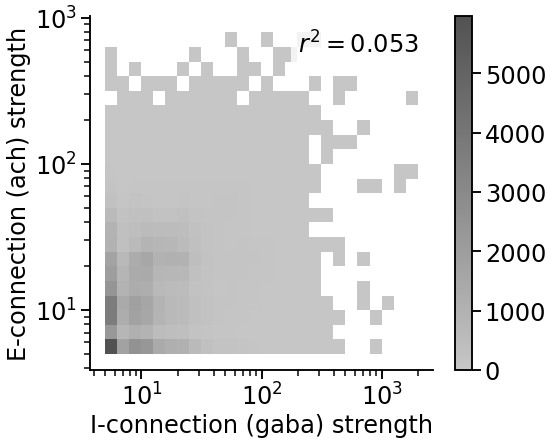

In [183]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

print("r^2 = {:.3f}".format(r2(gaba_strength, ach_strength)))
distp=sns.displot(
    x=gaba_strength, y=ach_strength,
    binwidth=(0.1,0.1), color='gray', cbar=True,
    log_scale=True, height=6, aspect=1.2,
)
distp.set_ylabels("E-connection (ach) strength", fontsize=24)
distp.set_xlabels("I-connection (gaba) strength", fontsize=24)
leg = plt.legend(labels=[],
           title='$r^2=${:.3f}'.format(r2(gaba_strength, ach_strength)))
leg.get_title().set_fontsize(24)
leg.get_frame().set_linewidth(0.0)
ax = distp.axes[0, 0]
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
distp.ax.collections[0].colorbar.ax.tick_params(labelsize=24)
plt.savefig('figures/stats-{}/strength-I-E.pdf'.format(ver), bbox_inches='tight')

In [83]:
all_ach_ach = []
for e in all_ach_pairs:
    if (e[1], e[0]) in all_ach_pairs:
        all_ach_ach.append((e[0], e[1]))

In [84]:
%%time
ach_strength_E1 = [edge_set_all_ach[(edge_set_all_ach[:,0] == all_ach_ach[i][0]) 
                  & (edge_set_all_ach[:,1] == all_ach_ach[i][1])][:,2][0] for i in range(len(all_ach_ach))]
ach_strength_E2 = [edge_set_all_ach[(edge_set_all_ach[:,0] == all_ach_ach[i][1]) 
                  & (edge_set_all_ach[:,1] == all_ach_ach[i][0])][:,2][0] for i in range(len(all_ach_ach))]

CPU times: user 12min 13s, sys: 12 ms, total: 12min 13s
Wall time: 12min 13s


In [170]:
# with open('saved/bi-EE-ach1-strength.pickle', 'wb') as handle:
#     pickle.dump(ach_strength_E1, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('saved/bi-EE-ach2-strength.pickle', 'wb') as handle:
#     pickle.dump(ach_strength_E2, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved/bi-EE-ach1-strength.pickle', 'rb') as handle:    
    ach_strength_E1 = pickle.load(handle)
with open('saved/bi-EE-ach2-strength.pickle', 'rb') as handle:    
    ach_strength_E2 = pickle.load(handle)

r^2 = 0.000


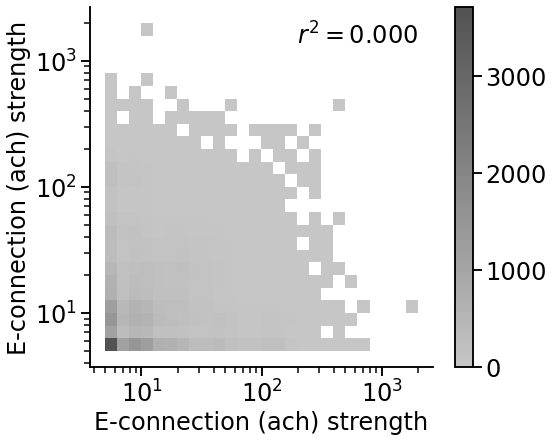

In [175]:
print("r^2 = {:.3f}".format(r2(ach_strength_E1, ach_strength_E2)))
distp=sns.displot(
    x=ach_strength_E1, y=ach_strength_E2,
    binwidth=(0.1,0.1), color='gray', cbar=True,
    log_scale=True, height=6, aspect=1.2,
)
distp.set_ylabels("E-connection (ach) strength", fontsize=24)
distp.set_xlabels("E-connection (ach) strength", fontsize=24)
leg = plt.legend(labels=[],
           title='$r^2=${:.3f}'.format(r2(ach_strength_E1, ach_strength_E2)))
leg.get_title().set_fontsize(24)
leg.get_frame().set_linewidth(0.0)
ax = distp.axes[0, 0]
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
distp.ax.collections[0].colorbar.ax.tick_params(labelsize=24)
plt.savefig('figures/stats-{}/strength-E-E.pdf'.format(ver), bbox_inches='tight')

In [87]:
all_ach_glut = []
for e in all_glut_pairs:
    if (e[1], e[0]) in all_ach_pairs:
        all_ach_glut.append((e[0], e[1]))

In [88]:
%%time
glut_strength = [edge_set_all_glut[(edge_set_all_glut[:,0] == all_ach_glut[i][0]) 
                  & (edge_set_all_glut[:,1] == all_ach_glut[i][1])][:,2][0] for i in range(len(all_ach_glut))]
ach_strength = [edge_set_all_ach[(edge_set_all_ach[:,0] == all_ach_glut[i][1]) 
                  & (edge_set_all_ach[:,1] == all_ach_glut[i][0])][:,2][0] for i in range(len(all_ach_glut))]

CPU times: user 6min 37s, sys: 4 ms, total: 6min 37s
Wall time: 6min 37s


In [89]:
# with open('saved/bi-IE-glut-strength.pickle', 'wb') as handle:
#     pickle.dump(glut_strength, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('saved/bi-IE-ach-strength.pickle', 'wb') as handle:
#     pickle.dump(ach_strength, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved/bi-IE-glut-strength.pickle', 'rb') as handle:    
    glut_strength = pickle.load(handle)
with open('saved/bi-IE-ach-strength.pickle', 'rb') as handle:    
    ach_strength = pickle.load(handle)

r^2 = 0.039


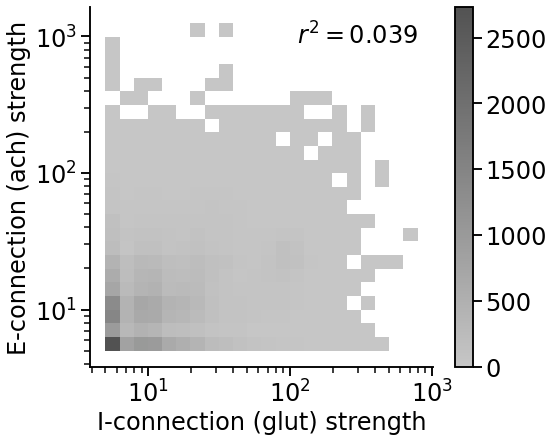

In [176]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

print("r^2 = {:.3f}".format(r2(glut_strength, ach_strength)))
distp=sns.displot(
    x=glut_strength, y=ach_strength,
    binwidth=(0.1,0.1), color='gray', cbar=True,
    log_scale=True, height=6, aspect=1.2,
)
leg = plt.legend(labels=[],
           title='$r^2=${:.3f}'.format(r2(glut_strength, ach_strength)))
leg.get_title().set_fontsize(24)
leg.get_frame().set_linewidth(0.0)
leg.get_title().set_fontsize(24)
leg.get_frame().set_linewidth(0.0)
ax = distp.axes[0, 0]
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
distp.set_ylabels("E-connection (ach) strength", fontsize=24)
distp.set_xlabels("I-connection (glut) strength", fontsize=24)
distp.ax.collections[0].colorbar.ax.tick_params(labelsize=24)
plt.savefig('figures/stats-{}/strength-I-E-glut.pdf'.format(ver), bbox_inches='tight')

### E-I Strength in Different Neuropil Graphs

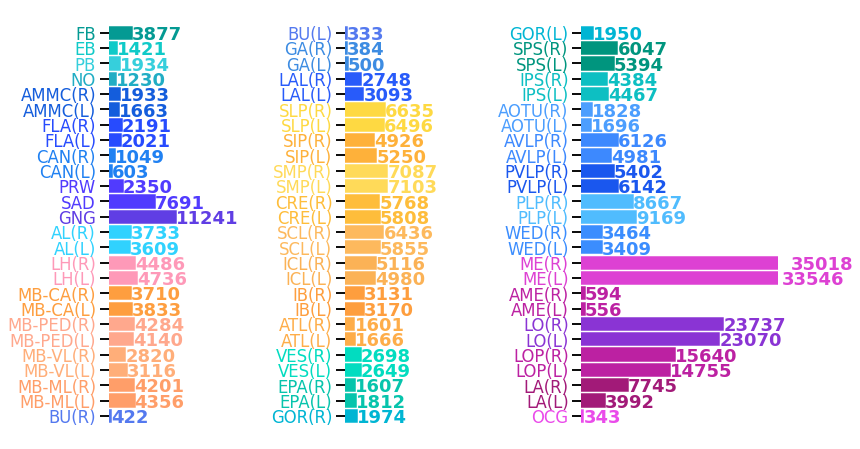

In [244]:
fig, axs = plt.subplots(1, 3, figsize=(12,8))
for i, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    vsizes = [g_np[n].num_vertices() for n in np.array(np_order)[26*i:26*(i+1)][::-1]]
    color_list = np.array(np_color)[26*i:26*(i+1)][::-1]
    barlist = ax.barh(np.array(np_names)[26*i:26*(i+1)][::-1], 
              vsizes)
    for barl, ytick, color in zip(barlist, ax.get_yticklabels(), color_list):
        ytick.set_color(color)
        barl.set_color(color)
    for i, v in enumerate(vsizes):
        ax.text(v + 6, i - 0.45, str(v), color=color_list[i], fontweight='bold')
    ax.set_xlim([0,32902])
plt.savefig('figures/stats-{}/np-subgraph-sizes.pdf'.format(ver), bbox_inches='tight')

In [92]:
def get_E_I_strength(np_na):
    np_edge_set = g_np[np_na].get_edges(eprops=[g_np[np_na].ep['syn_count'], g_np[np_na].ep['nt_type']])

    np_edge_set_all_ach = np_edge_set[(np_edge_set[:,3]==1)]
    np_edge_set_all_gaba = np_edge_set[(np_edge_set[:,3]==0)]
    np_all_ach_pairs = set((e[0], e[1]) for e in list(np_edge_set_all_ach[:,:2]))
    np_all_gaba_pairs = set((e[0], e[1]) for e in list(np_edge_set_all_gaba[:,:2]))

    np_all_ach_gaba = []
    for e in np_all_gaba_pairs:
        if (e[1], e[0]) in np_all_ach_pairs:
            np_all_ach_gaba.append((e[0], e[1]))

    np_gaba_strength = [np_edge_set_all_gaba[(np_edge_set_all_gaba[:,0] == np_all_ach_gaba[i][0]) 
                      & (np_edge_set_all_gaba[:,1] == np_all_ach_gaba[i][1])][:,2][0] for i in range(len(np_all_ach_gaba))]
    np_ach_strength = [np_edge_set_all_ach[(np_edge_set_all_ach[:,0] == np_all_ach_gaba[i][1]) 
                      & (np_edge_set_all_ach[:,1] == np_all_ach_gaba[i][0])][:,2][0] for i in range(len(np_all_ach_gaba))]
    
    return np_gaba_strength, np_ach_strength

In [93]:
np_gaba_strength, np_ach_strength = {}, {}

In [253]:
E_I_r_scores = []
for np_na in np_order:
    np_gaba_strength[np_na], np_ach_strength[np_na] = get_E_I_strength(np_na)
    if len(np_gaba_strength[np_na]) <=3:
        E_I_r_scores.append(0)
        continue
    E_I_r_scores.append(scipy.stats.pearsonr(np_gaba_strength[np_na], np_ach_strength[np_na])[0])

In [256]:
# E_I_r_scores

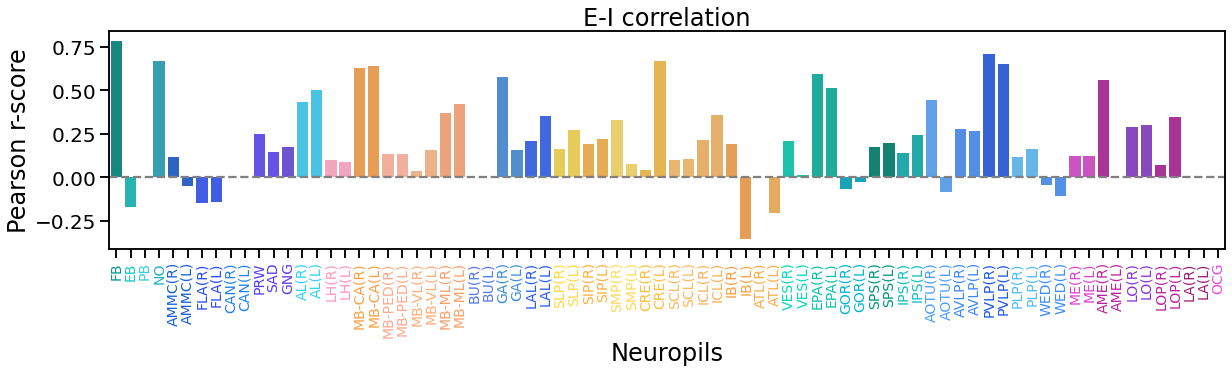

In [255]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

sns.barplot(x=np_names, 
            y=E_I_r_scores,
            palette=np_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_title("E-I correlation", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel("Pearson r-score", fontsize=24)
ax.set_xlabel("Neuropils", fontsize=24)
plt.savefig('figures/stats-{}/E-I-r-score-np.pdf'.format(ver), bbox_inches='tight')

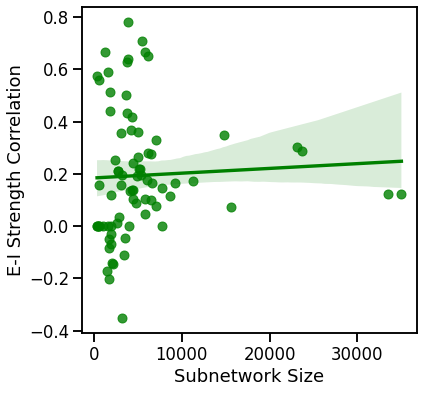

In [258]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

sns.regplot(x=[g_np[n].num_vertices() for n in np_order], 
            y=E_I_r_scores, color='g', 
            label="$r^2 = {:.3f}$".format(r2([g_np[n].num_vertices() for n in np_order], E_I_r_scores)))
ax.set_ylabel("E-I Strength Correlation")
ax.set_xlabel("Subnetwork Size")
plt.savefig('figures/stats-{}/EIstrength-vs-networksize.pdf'.format(ver), bbox_inches='tight')

skip PB
skip CAN_L
skip CAN_R
skip BU_L
skip BU_R
skip ATL_L
skip AME_R
skip LA_L
skip LA_R
skip OCG
CPU times: user 2min 12s, sys: 8.31 s, total: 2min 20s
Wall time: 2min 11s


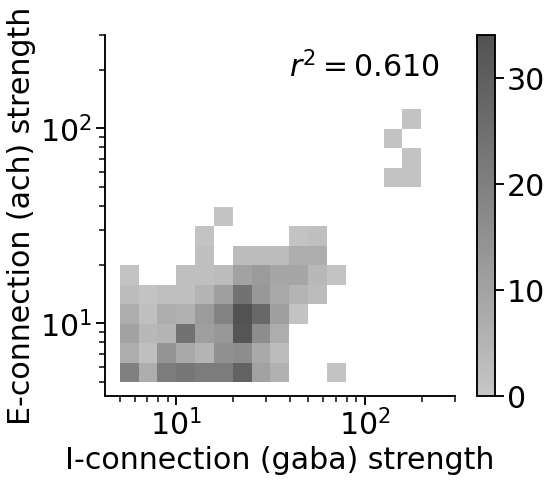

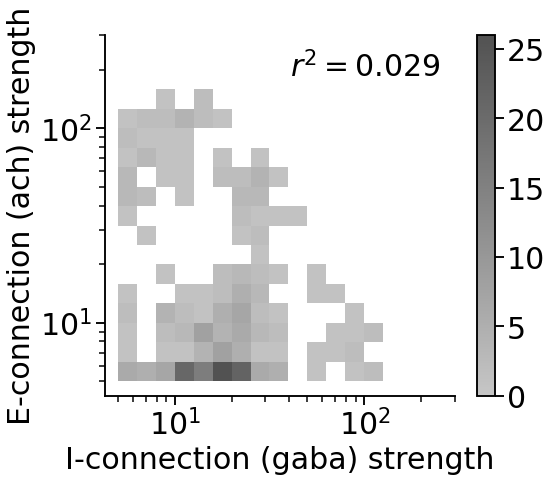

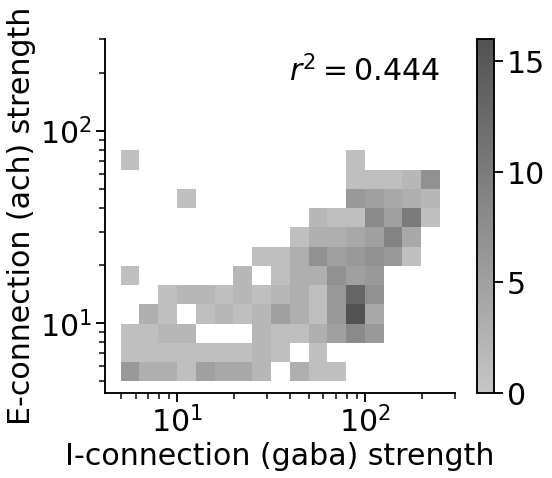

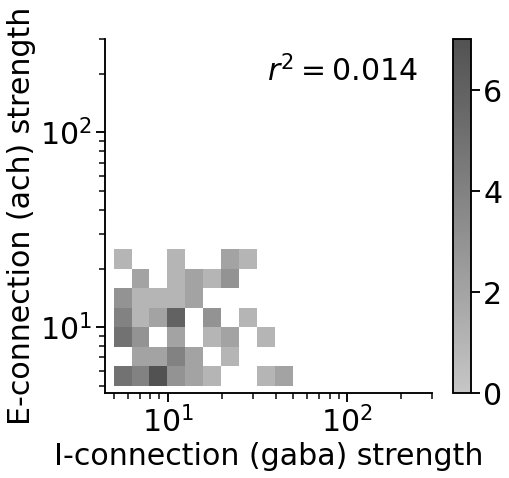

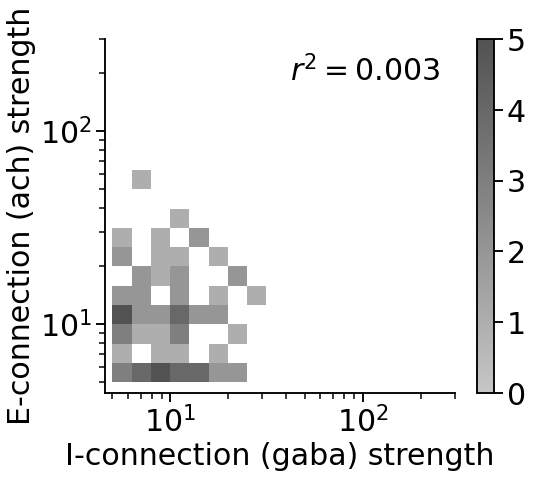

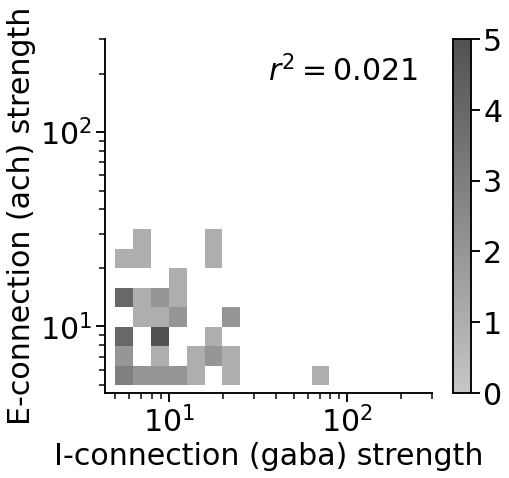

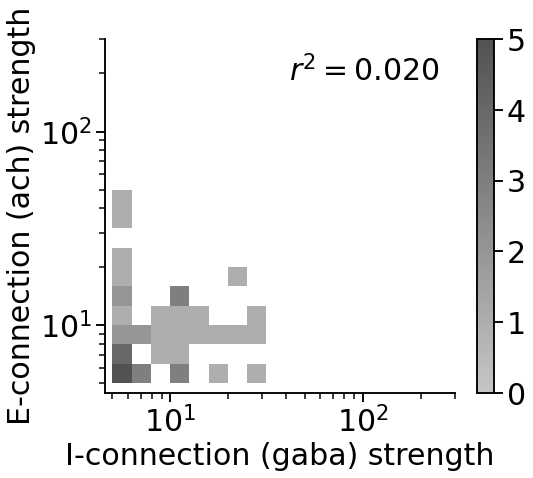

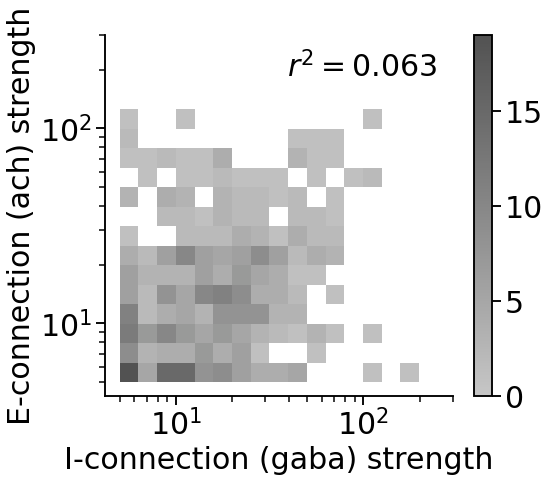

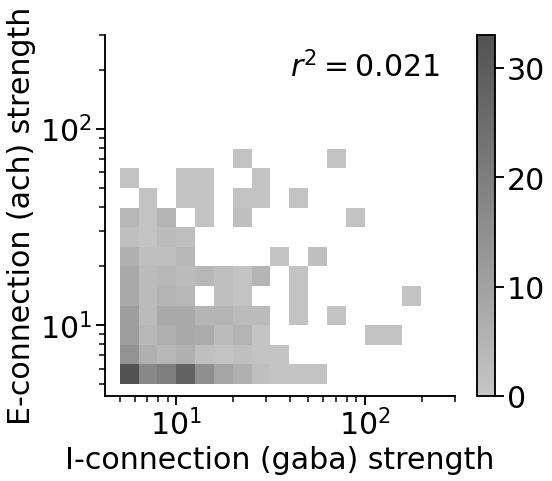

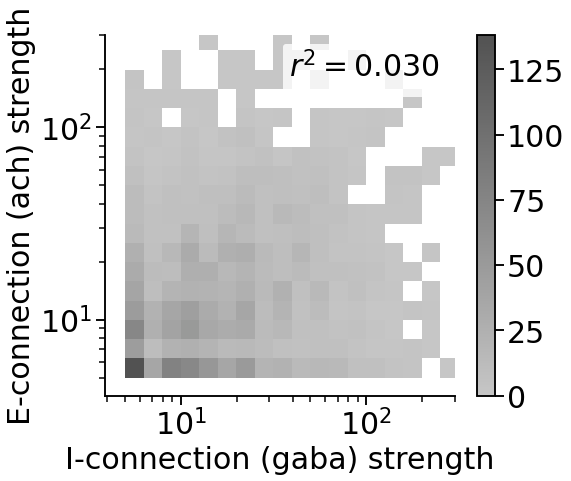

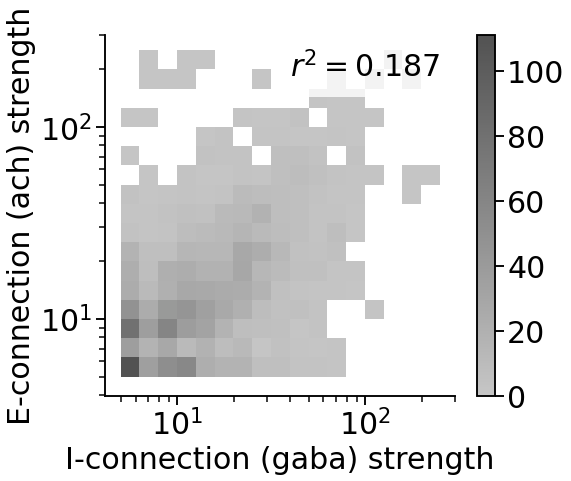

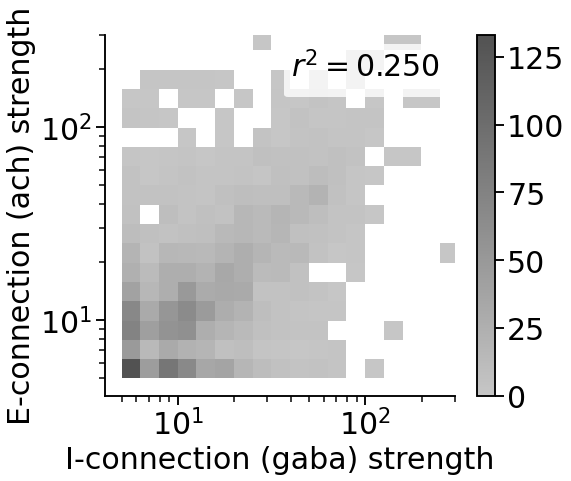

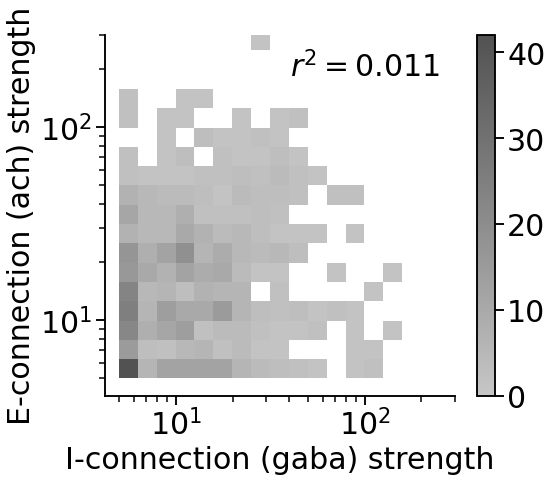

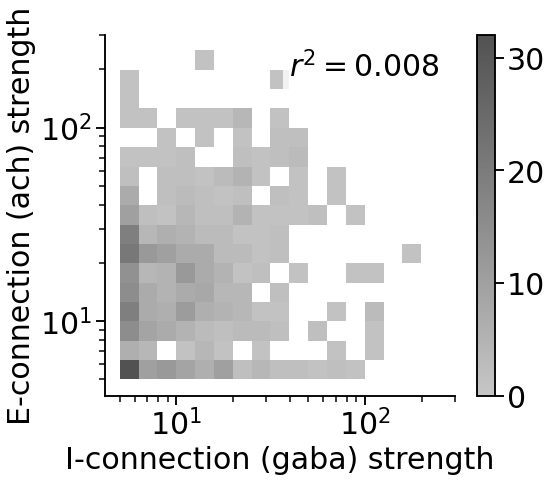

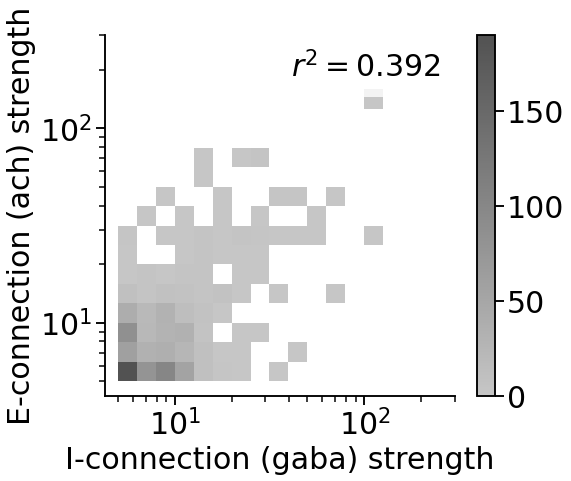

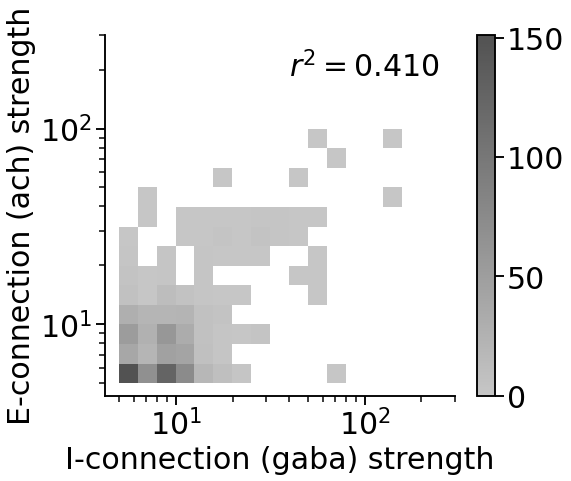

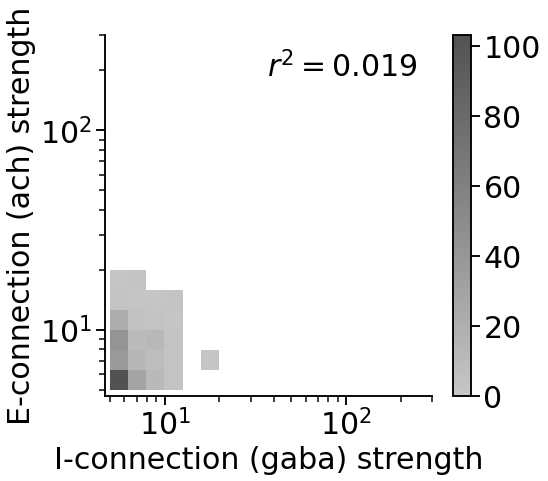

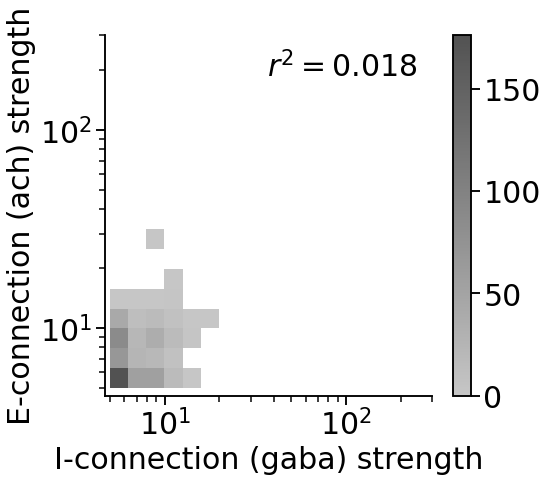

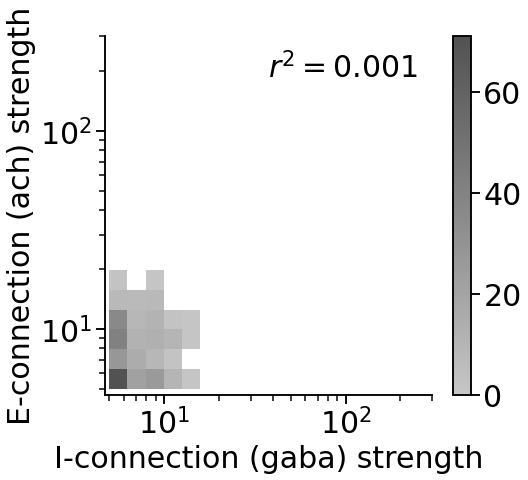

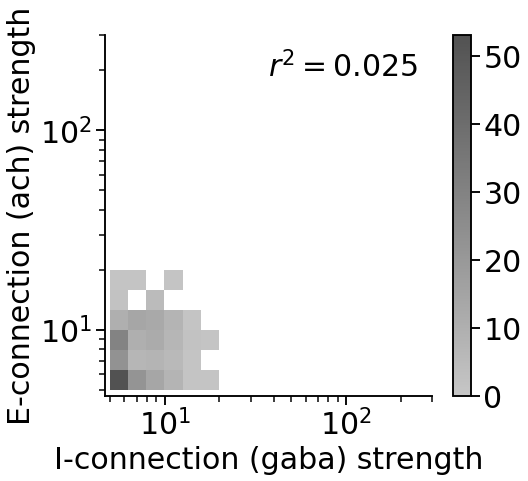

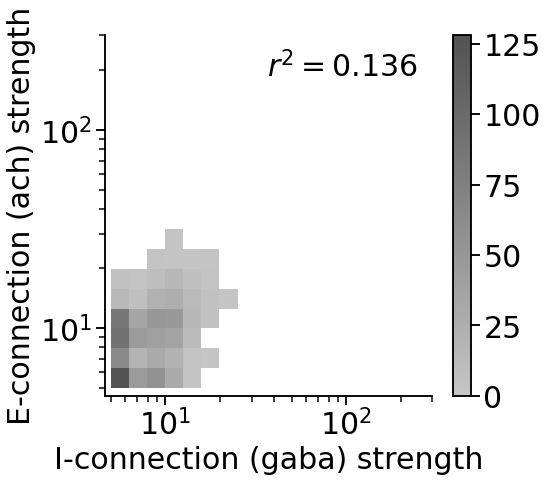

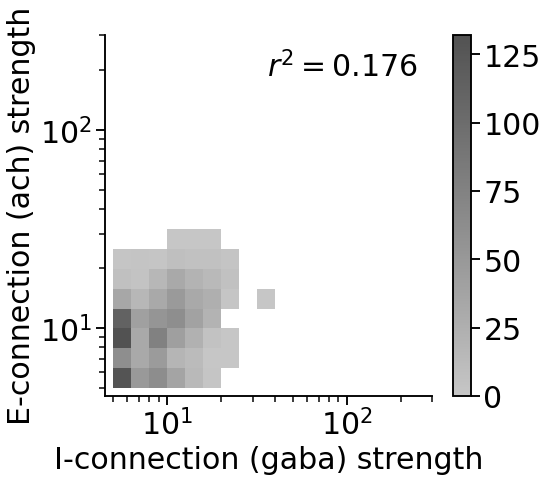

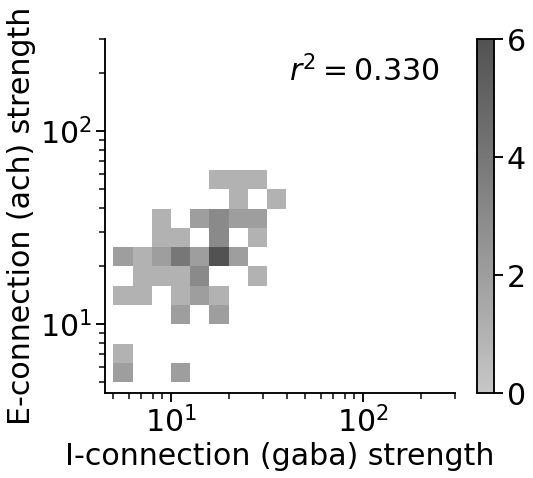

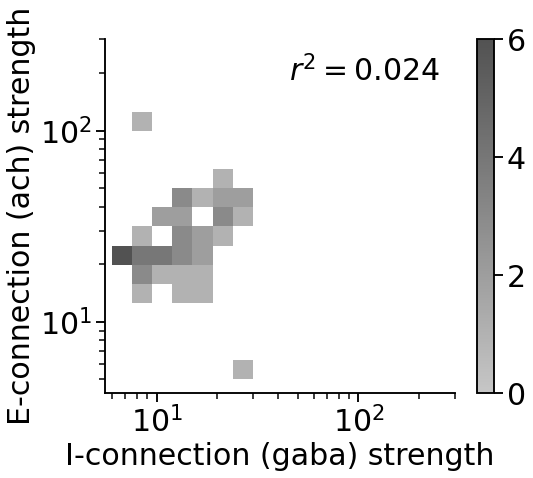

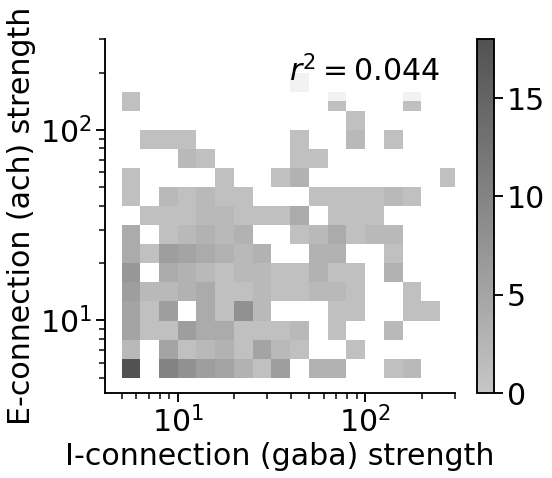

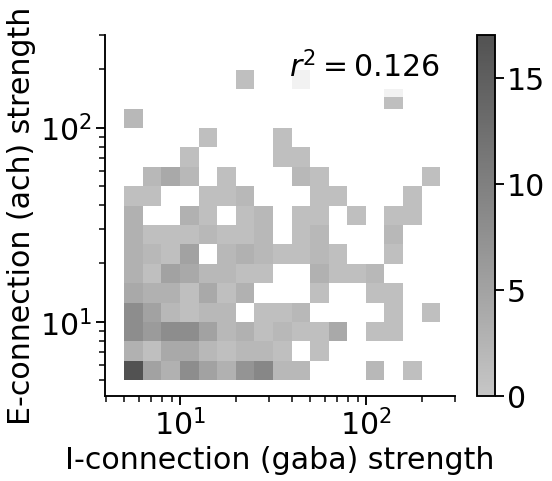

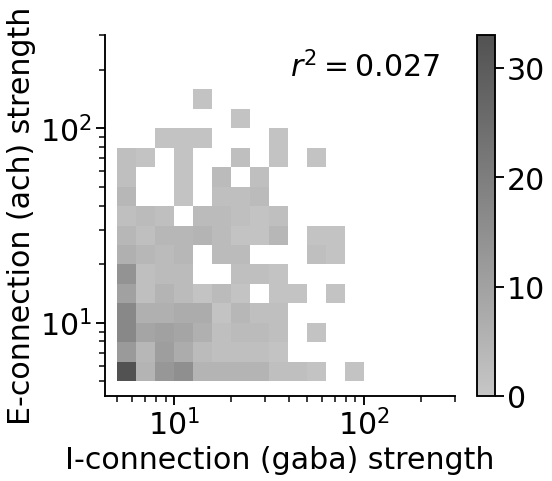

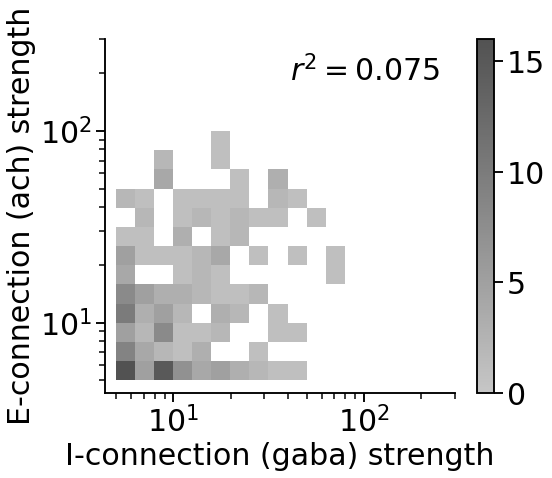

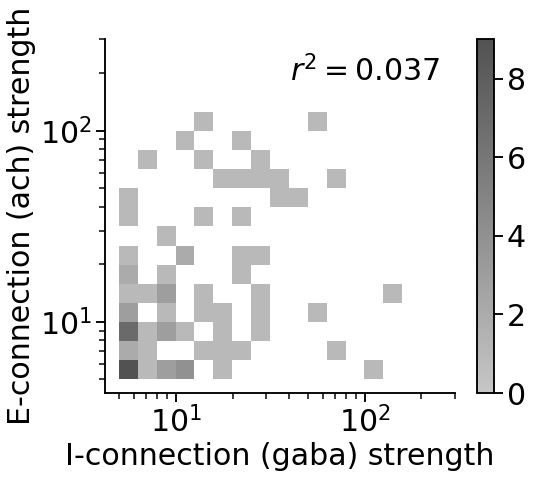

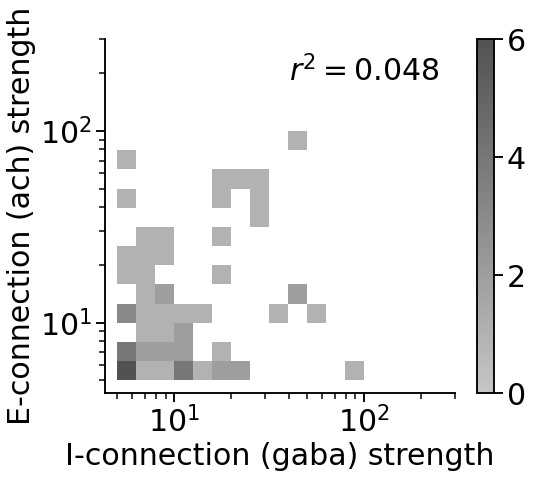

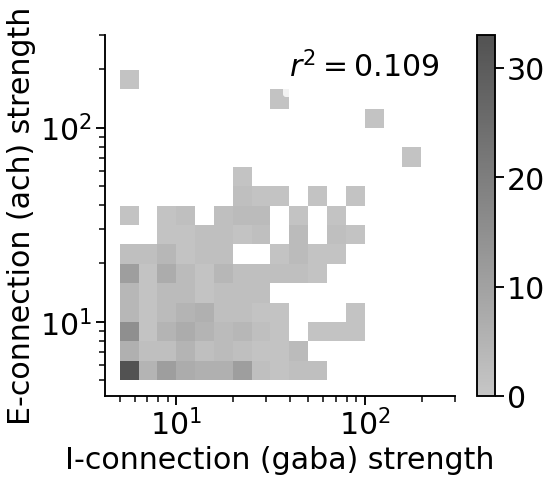

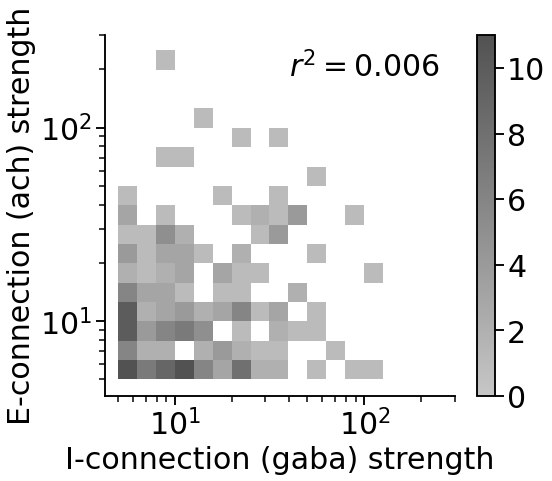

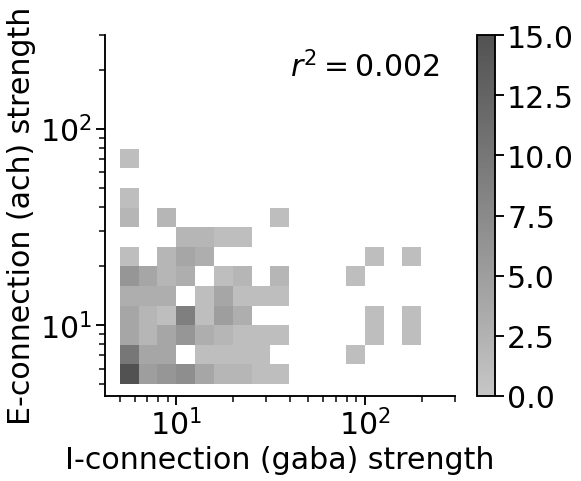

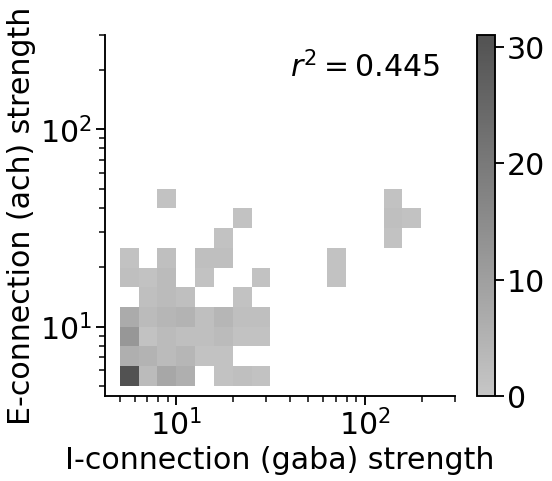

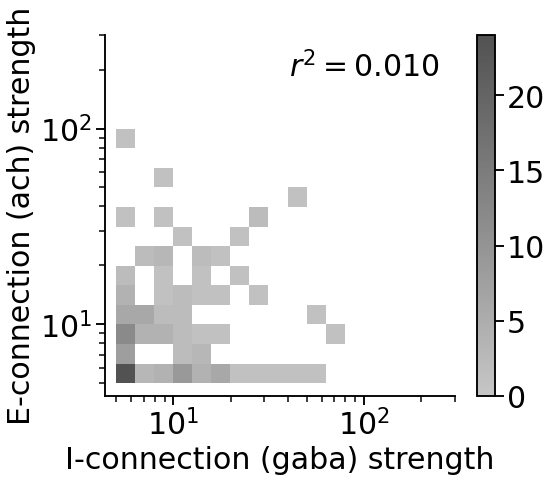

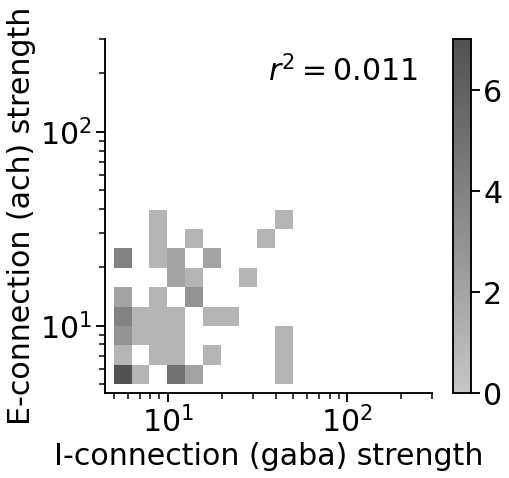

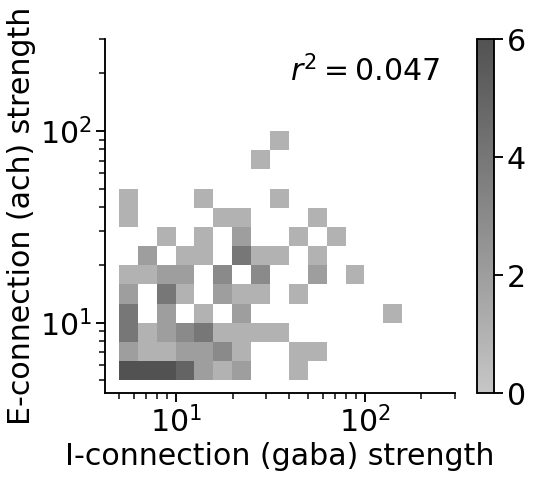

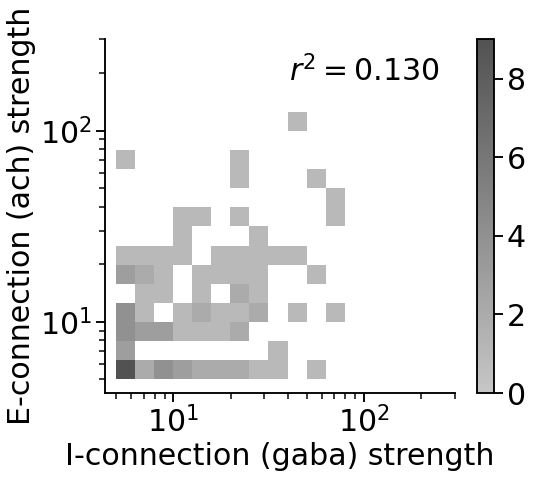

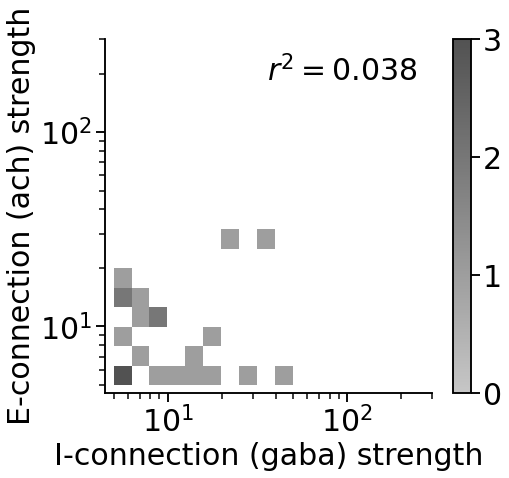

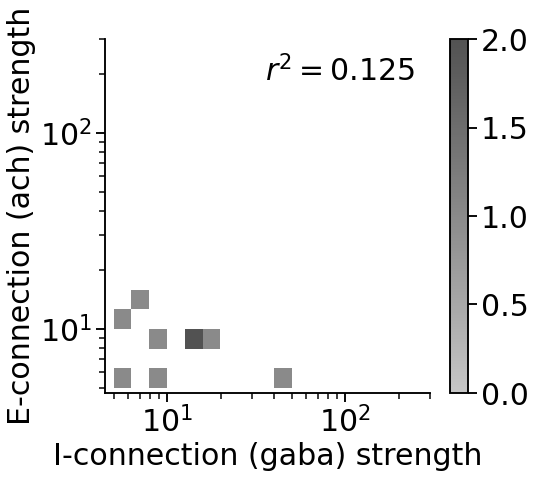

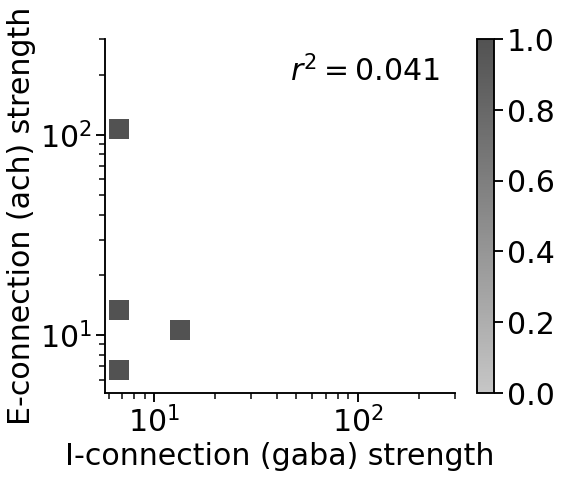

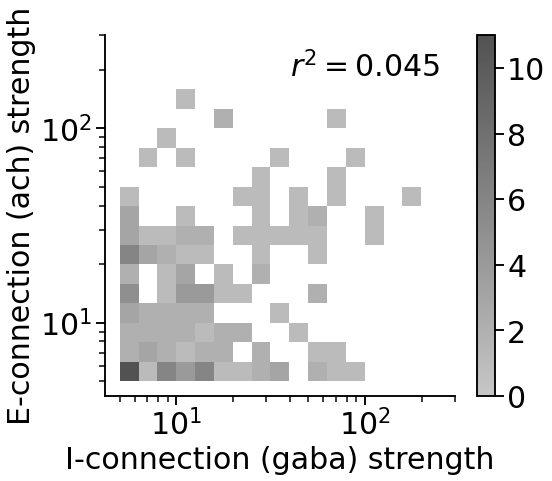

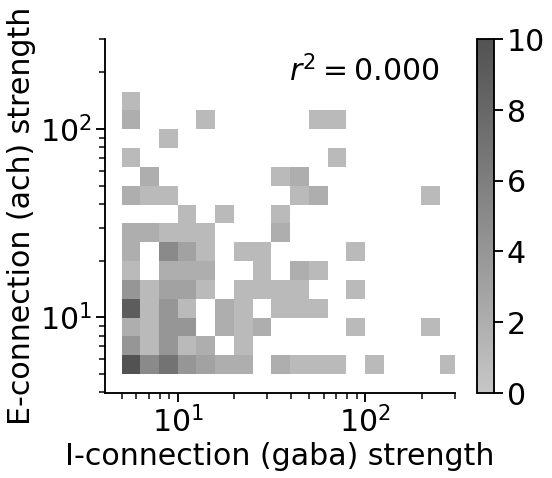

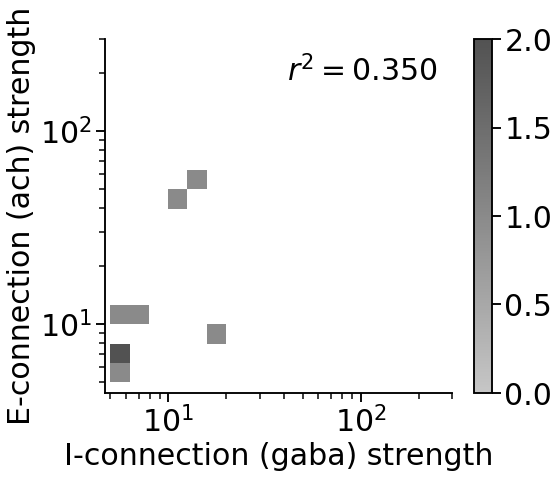

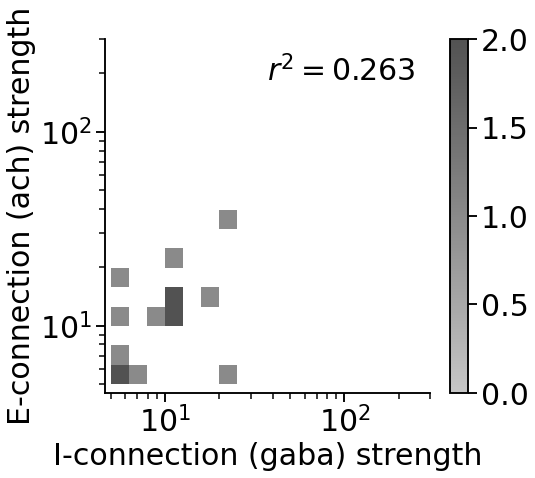

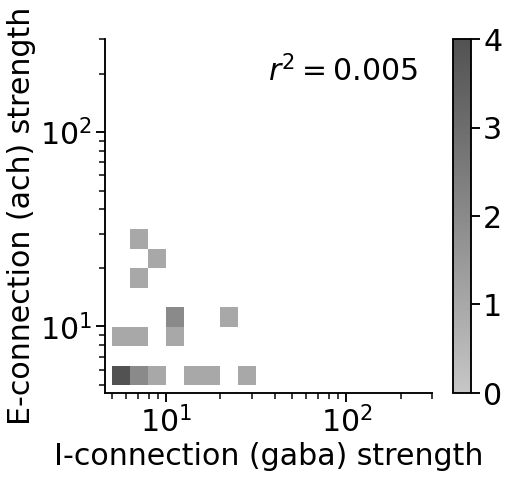

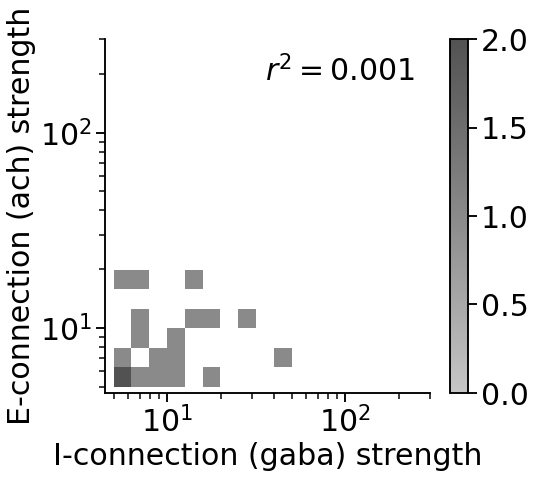

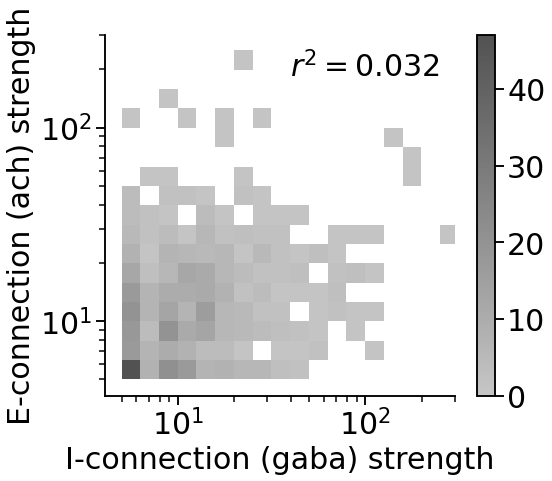

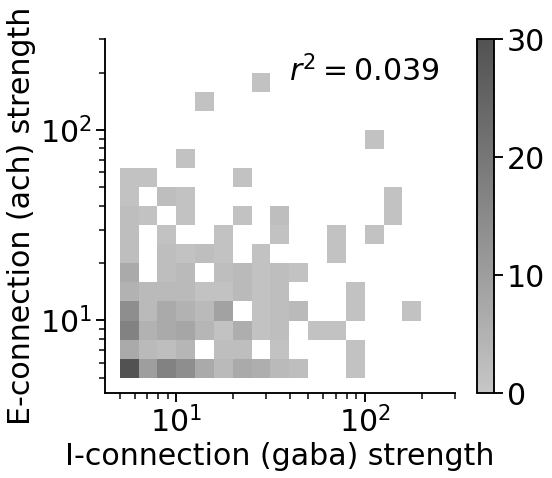

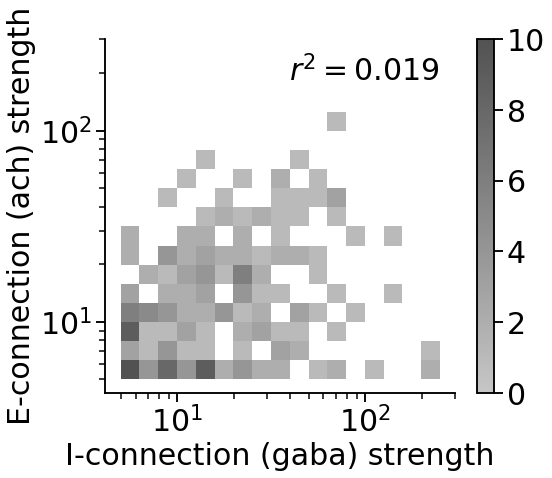

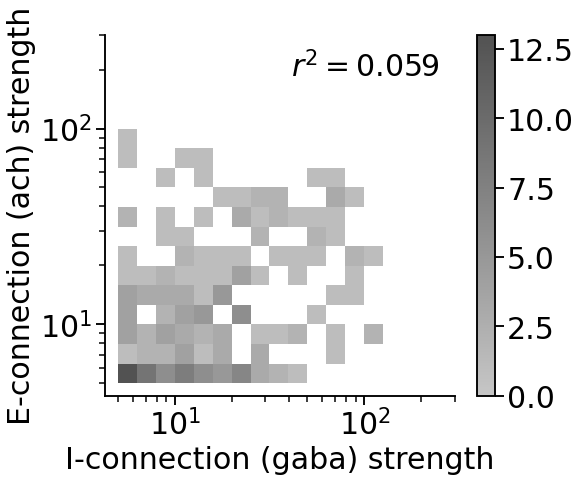

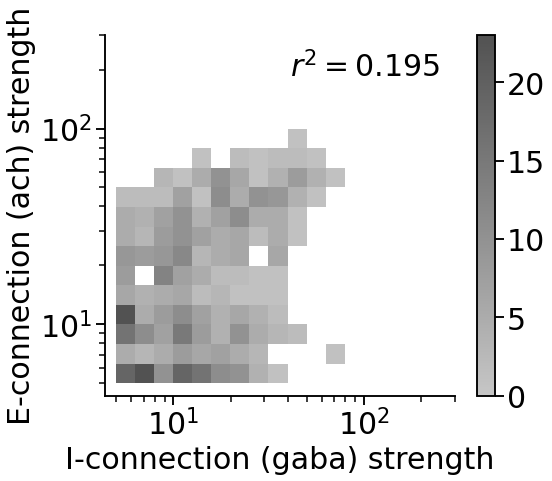

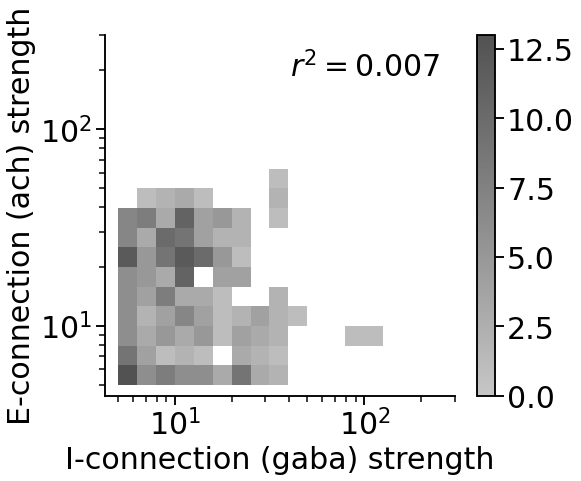

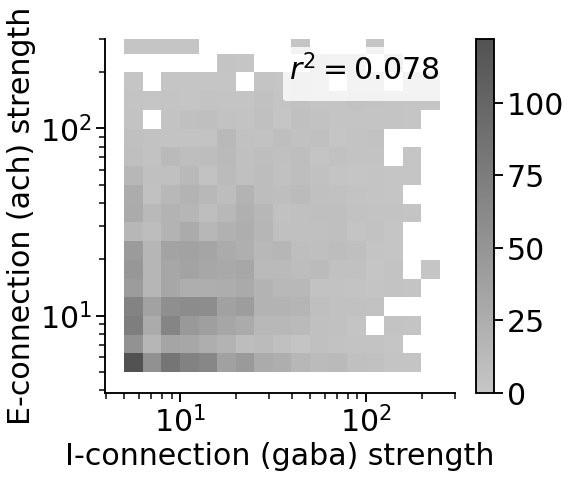

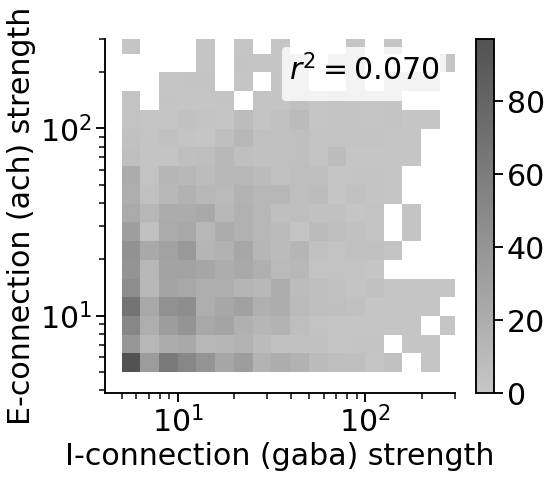

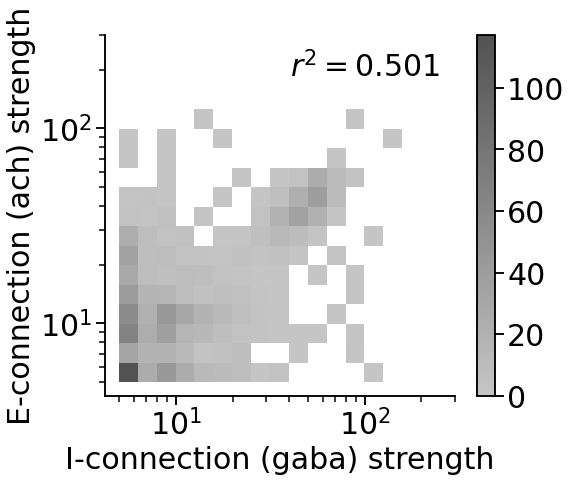

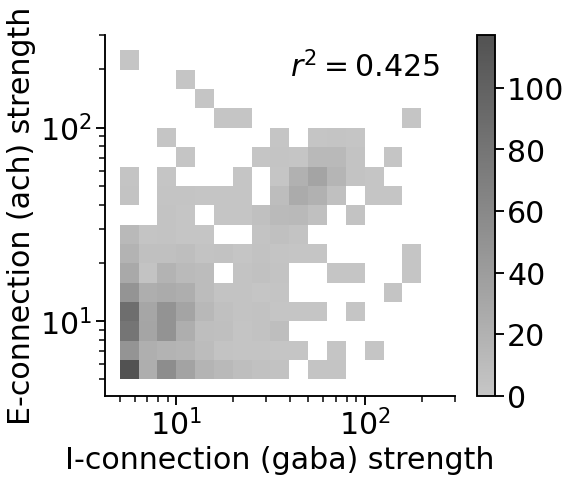

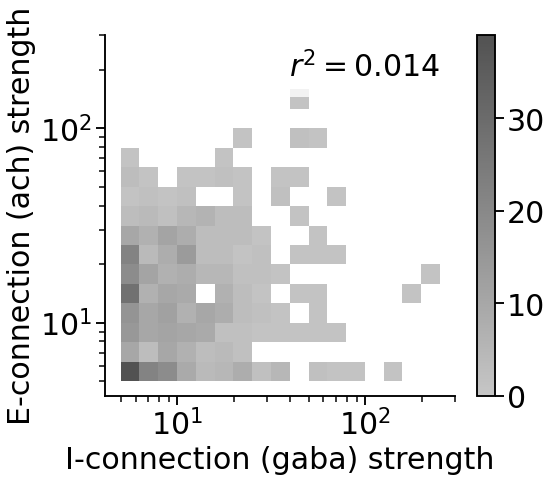

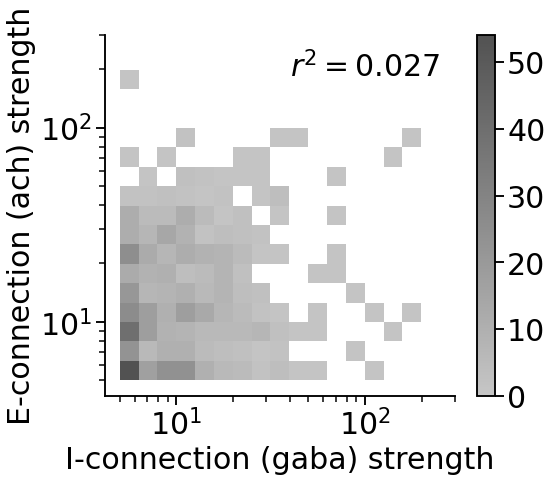

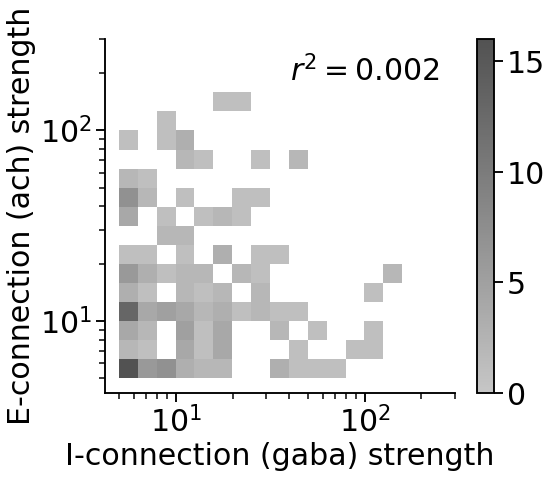

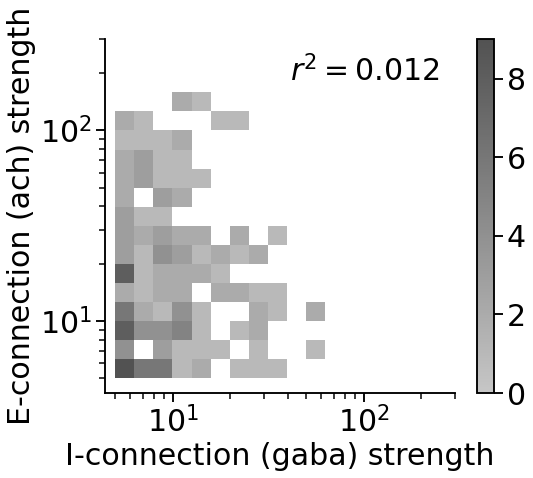

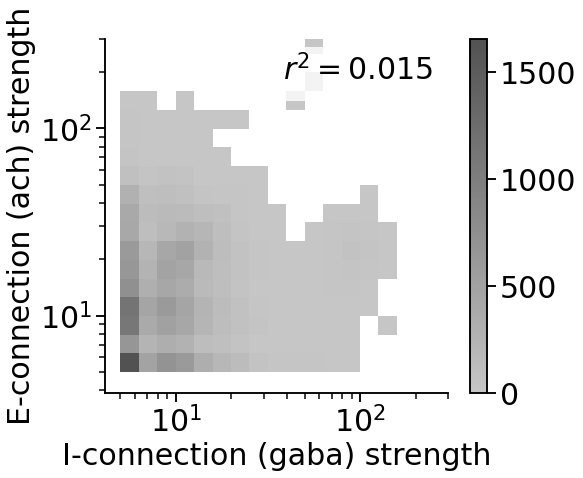

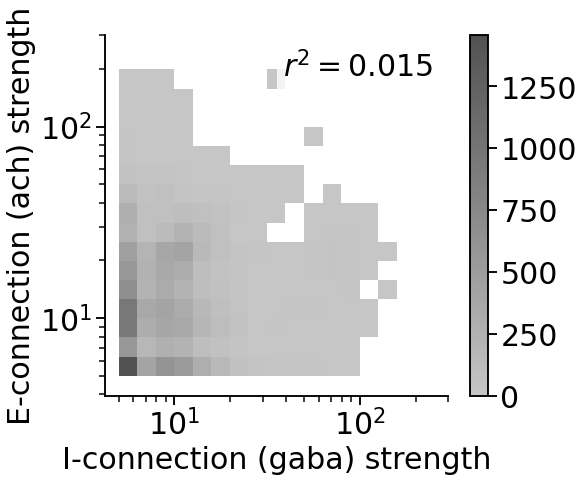

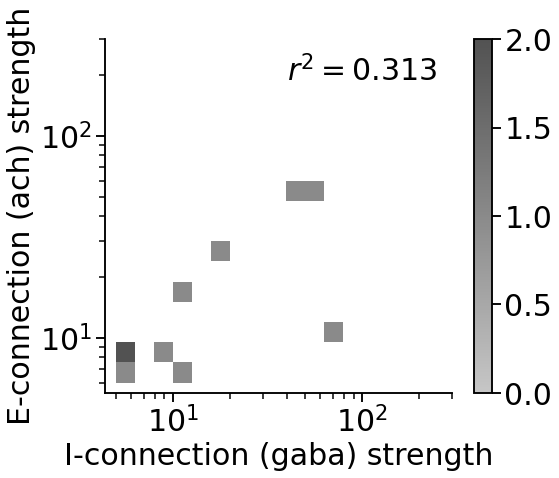

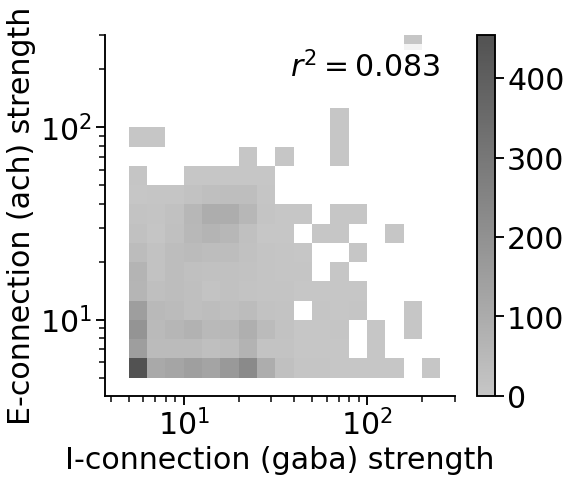

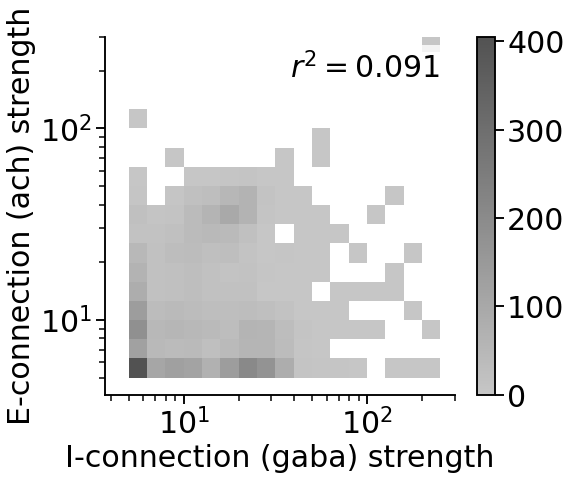

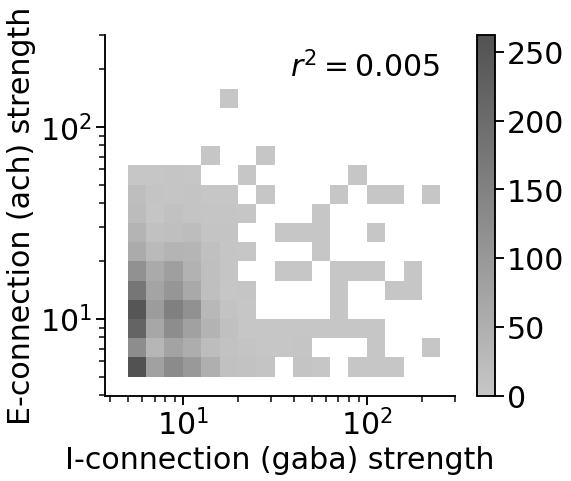

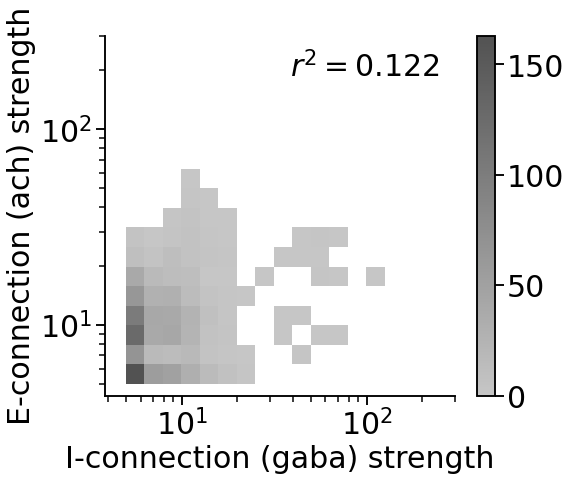

In [165]:
%%time

for np_na in np_order:
    np_gaba_strength[np_na], np_ach_strength[np_na] = get_E_I_strength(np_na)
    if len(np_gaba_strength[np_na]) <=3:
        print("skip", np_na)
        continue
    distp=sns.displot(
        x=np_gaba_strength[np_na], y=np_ach_strength[np_na],
        binwidth=(0.1,0.1), color='gray', cbar=True,
        log_scale=True, height=6, aspect=1.2,
    )
    leg = plt.legend(labels=[],
               title='$r^2=${:.3f}'.format(r2(np_gaba_strength[np_na], np_ach_strength[np_na])))
    leg.get_title().set_fontsize(30)
    leg.get_frame().set_linewidth(0.0)
    distp.set_ylabels("E-connection (ach) strength", fontsize=30)
    distp.set_xlabels("I-connection (gaba) strength", fontsize=30)
    distp.set(xlim=[0,300], ylim=[0,300])
    ax = distp.axes[0, 0]
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    distp.ax.collections[0].colorbar.ax.tick_params(labelsize=30)
    plt.savefig('figures/stats-{}/neuropil-I-E-same-scale/{}-strength-I-E.pdf'.format(ver, np_na), bbox_inches='tight')

### 3-Cell Feedforward Motif Type in the Whole Brain (w/ threshold)

In [134]:
%%time 

feedforward_edge_nt = {}

for e1 in g.edges():
    if not (e1.target(), e1.source()) in edge_set_pairs:
        for e2 in g.get_out_edges(e1.target(), eprops=[g.ep['nt_type']]):
            if not (e2[1], e2[0]) in edge_set_pairs:
                if ((e1.source(), e2[1]) in edge_set_pairs) and (not ((e2[1], e1.source()) in edge_set_pairs)):
                        for e3 in g.get_out_edges(e1.source(), eprops=[g.ep['nt_type']]):
                            if e3[1] == e2[1]:
                                nt1 = ntid2nt[g.ep['nt_type'][e1]][:-4]
                                nt2 = ntid2nt[e2[2]][:-4]
                                nt3 = ntid2nt[e3[2]][:-4]
                                
                                nt_chain = nt1 + "->" + nt2 + "->" + nt3

                                if nt_chain in feedforward_edge_nt.keys():
                                    feedforward_edge_nt[nt_chain] += 1
                                else:
                                    feedforward_edge_nt[nt_chain] =1

CPU times: user 13min 34s, sys: 2.07 s, total: 13min 36s
Wall time: 13min 41s


In [135]:
import pickle
with open('saved/feedforward-nt-type.pickle', 'wb') as handle:
    pickle.dump(feedforward_edge_nt, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved/feedforward-nt-type.pickle', 'rb') as handle:    
    feedforward_edge_nt = pickle.load(handle)

In [136]:
ffd_nt_order = np.argsort(list(feedforward_edge_nt.values()))[::-1]

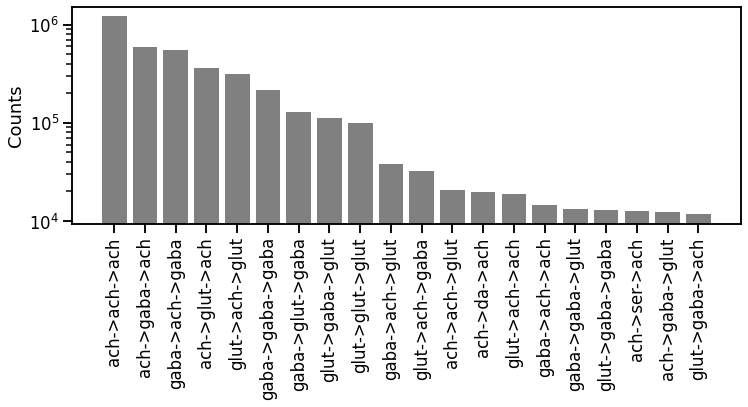

In [137]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(feedforward_edge_nt.keys()))[ffd_nt_order][:20], 
       np.array(list(feedforward_edge_nt.values()))[ffd_nt_order][:20],
       color='gray')
# ax.set_xticks(range(1,3))
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Counts')
ax.set_yscale('log')
plt.savefig('figures/stats-{}/ffd-re-nt-type.pdf'.format(ver), bbox_inches='tight')

In [138]:
uni_edge_nt_marginal = {n: cnt/sum(single_nt_counts) for n, cnt in zip([n[:-4] for n in single_nt_names], single_nt_counts)}

In [139]:
ffd_nt_independent = {}
for n1 in uni_edge_nt_marginal.keys():
    for n2 in uni_edge_nt_marginal.keys():
        for n3 in uni_edge_nt_marginal.keys():
            ffd_nt_independent[n1 + "->" + n2 + "->" + n3] = uni_edge_nt_marginal[n1] * uni_edge_nt_marginal[n2] * uni_edge_nt_marginal[n3]

In [303]:
ffd_nt_corr = {}
for n1 in uni_edge_nt_marginal.keys():
    for n2 in uni_edge_nt_marginal.keys():
        for n3 in uni_edge_nt_marginal.keys():
            ffd_nt_corr[n1 + "->" + n2 + "->" + n3] = uni_edge_nt_marginal[n1] * uni_edge_nt_marginal[n2] * int(n3 == n1)

In [140]:
ffd_nt_percent = {n: feedforward_edge_nt[n] / sum(feedforward_edge_nt.values()) for n in feedforward_edge_nt.keys()}

In [141]:
np.array(list(ffd_nt_percent.keys()))[ffd_nt_order][:20]

array(['ach->ach->ach', 'ach->gaba->ach', 'gaba->ach->gaba',
       'ach->glut->ach', 'glut->ach->glut', 'gaba->gaba->gaba',
       'gaba->glut->gaba', 'glut->gaba->glut', 'glut->glut->glut',
       'gaba->ach->glut', 'glut->ach->gaba', 'ach->ach->glut',
       'ach->da->ach', 'glut->ach->ach', 'gaba->ach->ach',
       'gaba->gaba->glut', 'glut->gaba->gaba', 'ach->ser->ach',
       'ach->gaba->glut', 'glut->gaba->ach'], dtype='<U16')

In [142]:
np.array([ffd_nt_independent[k] for k in ffd_nt_percent.keys()])[ffd_nt_order][:20]

array([0.22126314, 0.07795227, 0.02746303, 0.06147179, 0.01707822,
       0.00967538, 0.00762984, 0.00601676, 0.00474471, 0.02165687,
       0.02165687, 0.06147179, 0.00147043, 0.06147179, 0.07795227,
       0.00762984, 0.00762984, 0.00234261, 0.02165687, 0.02165687])

In [143]:
ffd_nt_percent['ach->ach->ach'], ffd_nt_percent['ach->ach->ach'] /ffd_nt_independent['ach->ach->ach']

(0.3049289587779956, 1.3781281497077944)

In [144]:
np.array(list(ffd_nt_percent.values()))[ffd_nt_order][:3]

array([0.30492896, 0.14932979, 0.13849663])

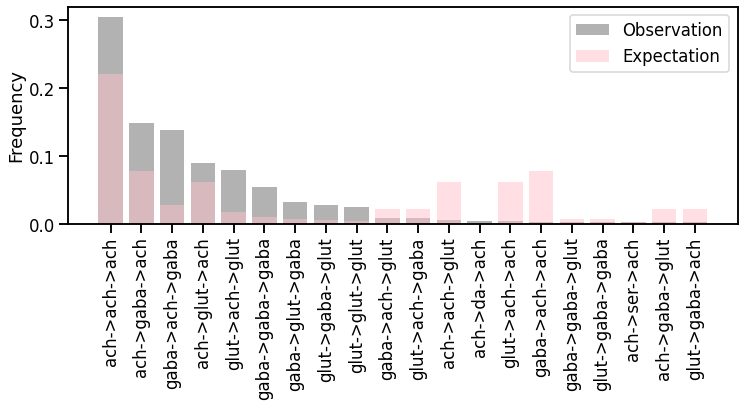

In [145]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(ffd_nt_percent.keys()))[ffd_nt_order][:20], 
       np.array(list(ffd_nt_percent.values()))[ffd_nt_order][:20],
       color='gray', alpha=0.6, label="Observation")
ax.bar(np.array([k for k in ffd_nt_percent.keys()])[ffd_nt_order][:20], 
       np.array([ffd_nt_independent[k] for k in ffd_nt_percent.keys()])[ffd_nt_order][:20],
       color='pink', alpha=0.5, label="Expectation")
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Frequency')
# ax.set_yscale('log')
ax.legend()
plt.savefig('figures/stats-{}/ffd-re-nt-type-percent-normscale.pdf'.format(ver), bbox_inches='tight')

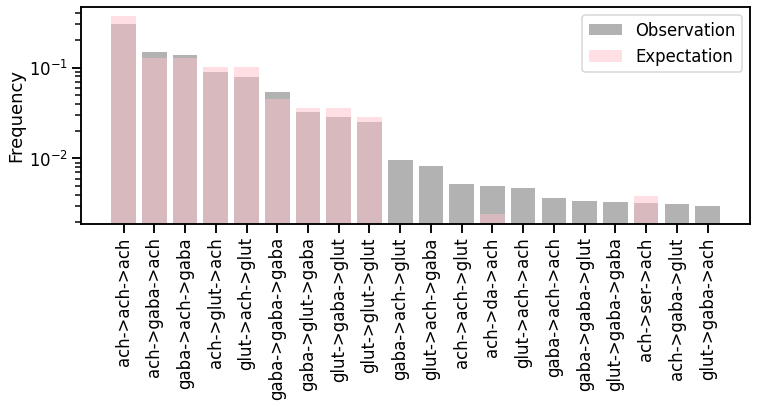

In [306]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(ffd_nt_percent.keys()))[ffd_nt_order][:20], 
       np.array(list(ffd_nt_percent.values()))[ffd_nt_order][:20],
       color='gray', alpha=0.6, label="Observation")
ax.bar(np.array([k for k in ffd_nt_percent.keys()])[ffd_nt_order][:20], 
       np.array([ffd_nt_corr[k] for k in ffd_nt_percent.keys()])[ffd_nt_order][:20],
       color='pink', alpha=0.5, label="Expectation")
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.legend()
plt.savefig('figures/stats-{}/ffd-re-nt-type-percent-corr.pdf'.format(ver), bbox_inches='tight')

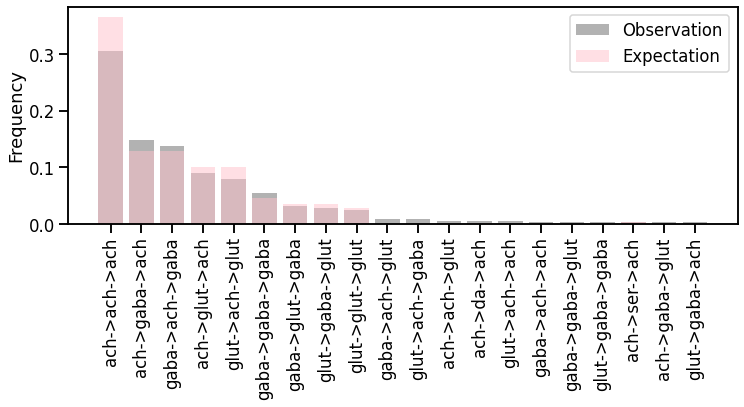

In [308]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(ffd_nt_percent.keys()))[ffd_nt_order][:20], 
       np.array(list(ffd_nt_percent.values()))[ffd_nt_order][:20],
       color='gray', alpha=0.6, label="Observation")
ax.bar(np.array([k for k in ffd_nt_percent.keys()])[ffd_nt_order][:20], 
       np.array([ffd_nt_corr[k] for k in ffd_nt_percent.keys()])[ffd_nt_order][:20],
       color='pink', alpha=0.5, label="Expectation")
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Frequency')
# ax.set_yscale('log')
ax.legend()
plt.savefig('figures/stats-{}/ffd-re-nt-type-percent-normscale-corr.pdf'.format(ver), bbox_inches='tight')

In [146]:
sum(feedforward_edge_nt.values())

3962277

<EdgePropertyMap object with value type 'int32_t', for Graph 0x7faa4d93dba8, at 0x7fa9103405f8>

In [615]:
# example ffd
strong_ffd = []
for e1 in g.edges():
    if g.ep['syn_count'][e1] >= 5:
        if not (e1.target(), e1.source()) in edge_set_pairs:
            for e2 in g.get_out_edges(e1.target(), eprops=[g.ep['nt_type'], g.ep['syn_count']]):
                if e2[3] >= 5: 
                    if not (e2[1], e2[0]) in edge_set_pairs:
                        if ((e1.source(), e2[1]) in edge_set_pairs) and (not ((e2[1], e1.source()) in edge_set_pairs)):
                                for e3 in g.get_out_edges(e1.source(), eprops=[g.ep['nt_type'], g.ep['syn_count']]):
                                    if e3[1] == e2[1] and e3[3] >= 5:
                                        nt1 = ntid2nt[g.ep['nt_type'][e1]][:-4]
                                        nt2 = ntid2nt[e2[2]][:-4]
                                        nt3 = ntid2nt[e3[2]][:-4]

                                        nt_chain = nt1 + "->" + nt2 + "->" + nt3

                                        strong_ffd.append(
                                              {"cell_id_1": nid2cid[e1.source()], 
                                               "cell_id_2": nid2cid[e2[0]], 
                                               "cell_id_3": nid2cid[e2[1]], 
                                               "syn_count_1->2": g.ep['syn_count'][e1], 
                                               "syn_count_2->3": e2[3], 
                                               "syn_count_1->3": e3[3], 
                                               "nt_type_1->2": nt1, 
                                               "nt_type_2->3": nt2, 
                                               "nt_type_1->3": nt3})

In [616]:
len(np.unique(pd.DataFrame(strong_ffd)[["cell_id_1", "cell_id_2", "cell_id_3"]].values.reshape(-1)))

113978

In [617]:
pd.DataFrame(strong_ffd)

cell_id_1           cell_id_2           cell_id_3  \
0        720575940596125868  720575940608552405  720575940611348834   
1        720575940596125868  720575940608552405  720575940635713375   
2        720575940596125868  720575940630768215  720575940620512950   
3        720575940596125868  720575940630768215  720575940634848875   
4        720575940597856265  720575940609624003  720575940622037139   
...                     ...                 ...                 ...   
3962272  720575940660868481  720575940643265992  720575940627190556   
3962273  720575940660868481  720575940643265992  720575940629148007   
3962274  720575940660868481  720575940643265992  720575940636387502   
3962275  720575940660868481  720575940643265992  720575940637252453   
3962276  720575940660868737  720575940622913063  720575940626553546   

         syn_count_1->2  syn_count_2->3  syn_count_1->3 nt_type_1->2  \
0                     5               7               7          ach   
1                     5               8               5          ach   
2                     5              26               5          ach   
3                     5               7              17          ach   
4                     8              30               6          ach   
...                 ...             ...             ...          ...   
3962272               5              25               9          ach   
3962273               5               8              14          ach   
3962274               5               6               5          ach   
3962275               5              10              10          ach   
3962276              23               5               6         gaba   

        nt_type_2->3 nt_type_1->3  
0               glut          ach  
1               glut          ach  
2               glut          ach  
3               glut          ach  
4               gaba          ach  
...              ...          ...  
3962272         glut          ach  
3962273         glut          ach  
3962274         glut          ach  
3962275         glut          ach  
3962276          ach          ach  

[3962277 rows x 9 columns]

In [618]:
pd.DataFrame(strong_ffd).to_csv("saved/strong-3-ffd.csv", index=False)

### 3-Cycle Motif Type in the Whole Brain (w/ threshold)

In [147]:
%%time 

cycle_edge_nt = {}

for e1 in g.edges():
    if not (e1.target(), e1.source()) in edge_set_pairs:
        for e2 in g.get_out_edges(e1.target(), eprops=[g.ep['nt_type']]):
            if not (e2[1], e2[0]) in edge_set_pairs:
                if ((e2[1], e1.source()) in edge_set_pairs) and (not ((e1.source(), e2[1]) in edge_set_pairs)):
                        for e3 in g.get_out_edges(e2[1], eprops=[g.ep['nt_type']]):
                            if e3[1] == e1.source():
                                nt1 = ntid2nt[g.ep['nt_type'][e1]][:-4]
                                nt2 = ntid2nt[e2[2]][:-4]
                                nt3 = ntid2nt[e3[2]][:-4]
                                
                                if nt1 <= nt2 and nt1 <= nt3:
                                    nt_chain = nt1 + "->" + nt2 + "->" + nt3
                                elif nt2 <= nt1 and nt2 <= nt3:
                                    nt_chain = nt2 + "->" + nt3 + "->" + nt1
                                elif nt3 <= nt1 and nt3 <= nt2:
                                    nt_chain = nt3 + "->" + nt1 + "->" + nt2

                                if nt_chain in cycle_edge_nt.keys():
                                    cycle_edge_nt[nt_chain] += 1
                                else:
                                    cycle_edge_nt[nt_chain] =1

CPU times: user 19min 49s, sys: 152 ms, total: 19min 49s
Wall time: 19min 50s


In [148]:
import pickle
with open('saved/cycle-nt-type.pickle', 'wb') as handle:
    pickle.dump(cycle_edge_nt, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('saved/cycle-nt-type.pickle', 'rb') as handle:    
    cycle_edge_nt = pickle.load(handle)

In [149]:
cycle_edge_nt_combined = {}
for k in cycle_edge_nt.keys():
    nt1, nt2, nt3 = k.split("->")
    if nt2 > nt3 and nt3 == nt1:
        new_key = nt3 + "->" + nt1 + "->" + nt2
        if new_key in cycle_edge_nt_combined.keys():
            cycle_edge_nt_combined[new_key] += cycle_edge_nt[k]
        else:
            cycle_edge_nt_combined[new_key] = cycle_edge_nt[k]
    else:
        if k in cycle_edge_nt_combined.keys():
            cycle_edge_nt_combined[k] += cycle_edge_nt[k]
        else:
            cycle_edge_nt_combined[k] = cycle_edge_nt[k]

In [150]:
cycle_edge_nt = cycle_edge_nt_combined

In [151]:
cycle_nt_order = np.argsort(list(cycle_edge_nt.values()))[::-1]

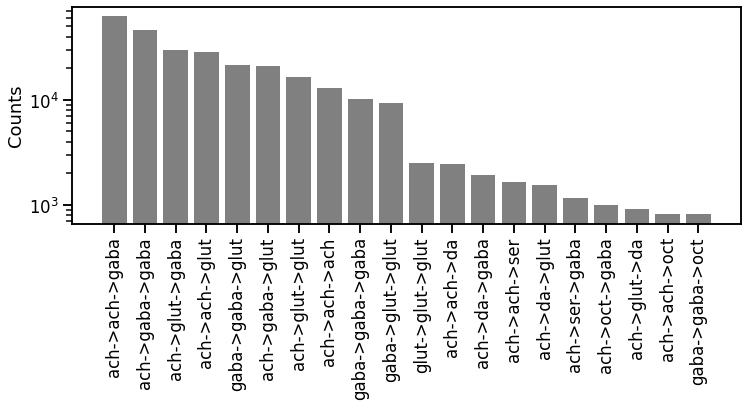

In [152]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(cycle_edge_nt.keys()))[cycle_nt_order][:20], 
       np.array(list(cycle_edge_nt.values()))[cycle_nt_order][:20]/3,
       color='gray')
# ax.set_xticks(range(1,3))
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Counts')
ax.set_yscale('log')
plt.savefig('figures/stats-{}/cycle-re-nt-type.pdf'.format(ver), bbox_inches='tight')

In [153]:
uni_edge_nt_marginal = {n: cnt/sum(single_nt_counts) for n, cnt in zip([n[:-4] for n in single_nt_names], single_nt_counts)}

In [154]:
ffd_nt_independent = {}
for n1 in uni_edge_nt_marginal.keys():
    for n2 in uni_edge_nt_marginal.keys():
        for n3 in uni_edge_nt_marginal.keys():
            ffd_nt_independent[n1 + "->" + n2 + "->" + n3] = uni_edge_nt_marginal[n1] * uni_edge_nt_marginal[n2] * uni_edge_nt_marginal[n3]

In [155]:
cycle_nt_percent = {n: cycle_edge_nt[n] / sum(cycle_edge_nt.values()) for n in cycle_edge_nt.keys()}

In [156]:
cycle_nt_percent['ach->gaba->gaba'], cycle_nt_percent['ach->gaba->gaba'] /ffd_nt_independent['ach->gaba->gaba']

(0.16398391776388482, 5.971078455399382)

In [157]:
cycle_nt_percent['ach->ach->gaba'], cycle_nt_percent['ach->ach->gaba'] /ffd_nt_independent['ach->ach->gaba']

(0.22188994788956296, 2.8464847038649888)

In [158]:
np.array(list(cycle_nt_percent.values()))[cycle_nt_order][:3]

array([0.22188995, 0.16398392, 0.1067658 ])

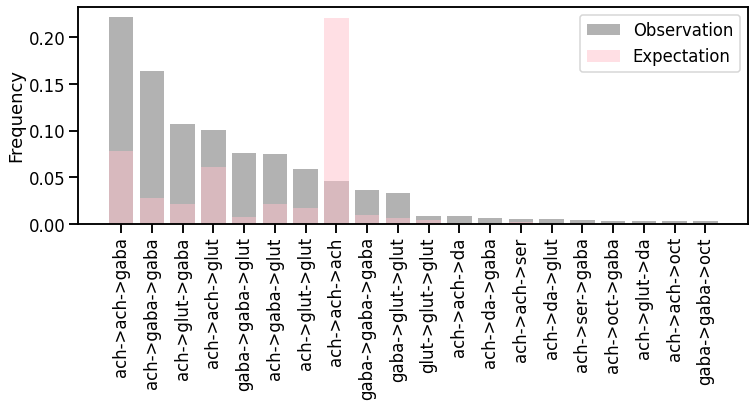

In [159]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.bar(np.array(list(cycle_nt_percent.keys()))[cycle_nt_order][:20], 
       np.array(list(cycle_nt_percent.values()))[cycle_nt_order][:20],
       color='gray', alpha=0.6, label="Observation")
ax.bar(np.array([k for k in cycle_nt_percent.keys()])[cycle_nt_order][:20], 
       np.array([ffd_nt_independent[k] for k in cycle_nt_percent.keys()])[cycle_nt_order][:20],
       color='pink', alpha=0.5, label="Expectation")
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Frequency')
# ax.set_yscale('log')
ax.legend()
plt.savefig('figures/stats-{}/cycle-re-nt-type-percent-normscale.pdf'.format(ver), bbox_inches='tight')

In [ ]:
# # strong cycle
strong_cycle = []
for e1 in g.edges():
    if g.ep['syn_count'][e1] >= 5:
        if not (e1.target(), e1.source()) in edge_set_pairs:
            for e2 in g.get_out_edges(e1.target(), eprops=[g.ep['nt_type'], g.ep['syn_count']]):
                if e2[3] >= 5: 
                    if not (e2[1], e2[0]) in edge_set_pairs:
                        if ((e2[1], e1.source()) in edge_set_pairs) and (not ((e1.source(), e2[1]) in edge_set_pairs)):
                                for e3 in g.get_out_edges(e2[1], eprops=[g.ep['nt_type'], g.ep['syn_count']]):
                                    if e3[1] == e1.source() and e3[3] >= 5:
                                        nt1 = ntid2nt[g.ep['nt_type'][e1]][:-4]
                                        nt2 = ntid2nt[e2[2]][:-4]
                                        nt3 = ntid2nt[e3[2]][:-4]
                                        strong_cycle.append(
                                              {"cell_id_1": nid2cid[e1.source()], 
                                               "cell_id_2": nid2cid[e2[0]], 
                                               "cell_id_3": nid2cid[e2[1]], 
                                               "syn_count_1->2": g.ep['syn_count'][e1], 
                                               "syn_count_2->3": e2[3], 
                                               "syn_count_3->1": e3[3], 
                                               "nt_type_1->2": nt1, 
                                               "nt_type_2->3": nt2, 
                                               "nt_type_3->1": nt3})

In [613]:
len(np.unique(pd.DataFrame(strong_cycle)[["cell_id_1", "cell_id_2", "cell_id_3"]].values.reshape(-1)))

66835

In [609]:
pd.DataFrame(strong_cycle)

cell_id_1           cell_id_2           cell_id_3  \
0       720575940597856265  720575940610239790  720575940619558966   
1       720575940597856265  720575940610239790  720575940639753013   
2       720575940597856265  720575940614718570  720575940607986953   
3       720575940597856265  720575940616561211  720575940607986953   
4       720575940597856265  720575940618011988  720575940615949791   
...                    ...                 ...                 ...   
841669  720575940660865409  720575940624265511  720575940628982939   
841670  720575940660865409  720575940627747859  720575940609659331   
841671  720575940660865409  720575940629006697  720575940609659331   
841672  720575940660865409  720575940639812174  720575940609659331   
841673  720575940660865409  720575940645875054  720575940609659331   

        syn_count_1->2  syn_count_2->3  syn_count_3->1 nt_type_1->2  \
0                   12               5               6          ach   
1                   12               6               6          ach   
2                   18              18               6          ach   
3                    6              16               6          ach   
4                    8               8               9          ach   
...                ...             ...             ...          ...   
841669              10               6               6          ach   
841670               6              25               5          ach   
841671               5              19               5          ach   
841672               5               5               5          ach   
841673               5              38               5          ach   

       nt_type_2->3 nt_type_3->1  
0               ach         glut  
1               ach         glut  
2               ach         gaba  
3              gaba         gaba  
4              glut         gaba  
...             ...          ...  
841669         glut         glut  
841670         gaba         gaba  
841671         gaba         gaba  
841672          ach         gaba  
841673         gaba         gaba  

[841674 rows x 9 columns]

In [619]:
pd.DataFrame(strong_cycle).to_csv("saved/strong-3-cycles.csv", index=False)

In [184]:
cycle_nt_dist = {}
for k in cycle_edge_nt.keys():
    for nt in k.split("->"):
        if nt in cycle_nt_dist.keys():
            cycle_nt_dist[nt] += cycle_edge_nt[k]
        else:
            cycle_nt_dist[nt] = cycle_edge_nt[k]

In [185]:
ffd_nt_dist = {}
for k in feedforward_edge_nt.keys():
    for nt in k.split("->"):
        if nt in ffd_nt_dist.keys():
            ffd_nt_dist[nt] += feedforward_edge_nt[k]
        else:
            ffd_nt_dist[nt] = feedforward_edge_nt[k]

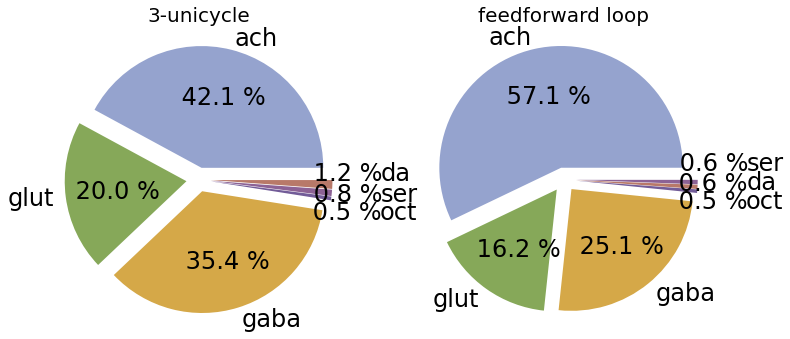

In [187]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
patches, texts, autotexts = axs[0].pie(cycle_nt_dist.values(), 
       explode=[0.1]*6,
       labels=[n for n in cycle_nt_dist.keys()], 
       colors=[nt_colors[nt2ntid[n+"_sum"]] for n in cycle_nt_dist.keys()],
       autopct ='% 1.1f %%')
texts[4]._x += 0.30
texts[5]._x += 0.30
texts[5]._y += 0.10
texts[3]._x += 0.30
texts[3]._y -= 0.10
autotexts[4]._x += 0.50
autotexts[4]._y -= 0.05
autotexts[5]._x += 0.50
autotexts[5]._y += 0.08
autotexts[3]._x += 0.50
autotexts[3]._y -= 0.17
axs[0].set_title("3-unicycle", fontsize=20)

for label in axs[0].texts:
    label.set_fontsize(24)

patches, texts, autotexts = axs[1].pie(ffd_nt_dist.values(), 
       explode=[0.1]*6,
       labels=[n for n in ffd_nt_dist.keys()], 
       colors=[nt_colors[nt2ntid[n+"_sum"]] for n in ffd_nt_dist.keys()],
       autopct ='% 1.1f %%')
texts[5]._x += 0.30
texts[5]._y += 0.16
texts[4]._x += 0.30
texts[4]._y += 0.04
texts[3]._x += 0.30
texts[3]._y -= 0.07
autotexts[5]._x += 0.50
autotexts[5]._y += 0.15
autotexts[4]._x += 0.50
autotexts[4]._y += 0.01
autotexts[3]._x += 0.50
autotexts[3]._y -= 0.12
axs[1].set_title("feedforward loop", fontsize=20)

for label in axs[1].texts:
    label.set_fontsize(24)
    
plt.savefig('figures/stats-{}/three-motif-nt-type.pdf'.format(ver), bbox_inches='tight')

### 3-Cell Motif Distribution in Neuropils

In [239]:
import pickle

np_motif_profiles_agg = {}
np_er_motif_profiles_agg = {}
np_cfg_motif_profiles_agg = {}
np_cfg_motif_profiles_agg_std = {}

for np_n in np_order:
    try:
        with open('saved/neuropil-motifs-630/{}-v630-cfg-motif.pickle'.format(np_n), 'rb') as handle:
            np_cfg_motif_profiles = pickle.load(handle)
        with open('saved/neuropil-motifs-630/{}-v630-motif.pickle'.format(np_n), 'rb') as handle:
            np_motif_profiles = pickle.load(handle)
    except:
        print(np_n, "missing")
        continue
    
    u = g_np[np_n]
    
    if u.num_vertices() == 0:
        print("zero vertex:", np_n)
        continue
    elif u.num_edges() == 0:
        print("zero edge:", np_n)
        continue
        
    elif len(np_motif_profiles[np_n][1]) < 13:
        print("too sparse", np_n)
        continue
        
    elif min([len(x) for x in np_cfg_motif_profiles[np_n]]) < 13:
        print("too sparse after rand", np_n)
        continue
        
    p_conn = u.num_edges() / u.num_vertices() / (u.num_vertices()-1)
    p_type = {"uni": p_conn*(1-p_conn), "bi": p_conn*p_conn, "null": (1-p_conn)**2}

    p_motif = [
        3 * p_type["uni"]**2 * p_type["null"],
        3 * p_type["uni"]**2 * p_type["null"],
        6 * p_type["uni"]**2 * p_type["null"],
        6 * p_type["uni"]**3,
        6 * p_type["uni"] * p_type["bi"] * p_type["null"],
        6 * p_type["uni"] * p_type["bi"] * p_type["null"],
        2 * p_type["uni"]**3,
        3 * p_type["uni"]**2 * p_type["bi"],
        3 * p_type["uni"]**2 * p_type["bi"],
        6 * p_type["uni"]**2 * p_type["bi"],
        3 * p_type["bi"]**2 * p_type["null"],
        6 * p_type["bi"]**2 * p_type["uni"],
        1 * p_type["bi"]**3
    ]

    er_motif = u.num_vertices() * (u.num_vertices()-1) * (u.num_vertices()-2) / 6 * np.array(p_motif)
    
    np_motif_profiles_agg[np_n] = np_motif_profiles[np_n][1]
    np_er_motif_profiles_agg[np_n] = er_motif
    np_cfg_motif_profiles_agg[np_n] = np.array(np_cfg_motif_profiles[np_n]).mean(0)
    np_cfg_motif_profiles_agg_std[np_n] = np.array(np_cfg_motif_profiles[np_n]).std(0)
    
    # also save plots
#     fig, ax = plt.subplots(1,1,figsize=(6,4))
#     ax.scatter(range(13), np.array(np_motif_profiles[np_n][1]) / er_motif, 
#                color=(0.6,0,0), marker='x')
#     parts = ax.violinplot(np.array(np_cfg_motif_profiles[np_n]) / er_motif, range(13),
#                   showmeans=False, showextrema=False)

#     for pc in parts['bodies']:
#         pc.set_facecolor('gray')
#         pc.set_edgecolor('black')
#         pc.set_alpha(0.5)

#     quartile1, medians, quartile3 = np.percentile(np.array(np_cfg_motif_profiles[np_n]) / er_motif, 
#                                                   [5, 50, 95], axis=0)

#     inds = np.arange(1, len(medians) + 1)
#     ax.scatter(range(13), medians, marker='o', color='gray', s=12, zorder=3)
#     ax.vlines(range(13), quartile1, quartile3, color='gray', linestyle='-', lw=1)
#     plt.axhline(0.5,color='gray', linestyle='--')
#     ax.set_xticks(range(13))
#     ax.set_yscale('log')
#     plt.savefig("figures/neuropil-motif-571/{}-motif.pdf".format(np_n), bbox_inches="tight")

In [240]:
abs_cnt = np.concatenate([np.array(np_motif_profiles_agg[np_n]).reshape(1,-1) for np_n in np_order])
er_cnt = np.concatenate([np.array(np_er_motif_profiles_agg[np_n]).reshape(1,-1) for np_n in np_order])
cfg_cnt = np.concatenate([np.array(np_cfg_motif_profiles_agg[np_n]).reshape(1,-1) for np_n in np_order])
cfg_std = np.concatenate([np.array(np_cfg_motif_profiles_agg_std[np_n]).reshape(1,-1) for np_n in np_order])

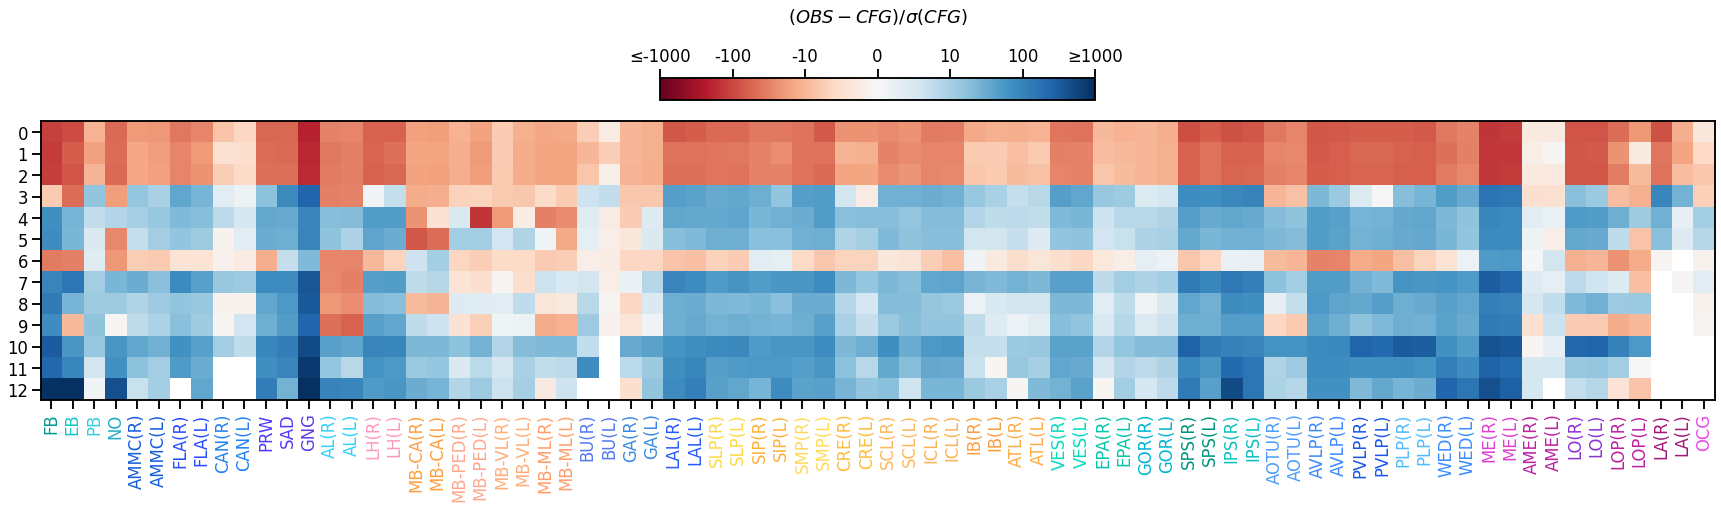

In [242]:
# visualize single rule matrix
import matplotlib as mpl

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
    
# define symlog
def my_log(x):    
    return np.log10(np.abs(x) + 1) * np.sign(x)
        

norm = MidpointNormalize(vmin=-3, vmax=3, midpoint=0)

fig, ax = plt.subplots(1, 1, figsize=(30,8))
rule_map = ax.imshow(my_log((abs_cnt/cfg_std - cfg_cnt/cfg_std).T), 
                      cmap='RdBu', norm=norm)
ax.set_xticks(range(78))
ax.set_xticklabels(np_names, rotation = 90)
for xtick, color in zip(ax.get_xticklabels(), np_color):
    xtick.set_color(color)
ax.set_yticks(range(13))

cbar = plt.colorbar(rule_map, ax=ax, fraction=0.05, 
             orientation='horizontal', location='top',
             label="$(OBS-CFG)/\sigma(CFG)$\n")
cbar.ax.set_xticklabels(['≤-1000', '-100', "-10", "0", "10", "100", "≥1000"])
plt.savefig('figures/stats-{}/neuropil-motif.pdf'.format(ver), bbox_inches='tight')

### 3-Cell Motif Strength in Neuropils

In [529]:
import pickle

motif_strength_mean_agg = {}

for np_p in np_order:
    if os.path.exists('saved/neuropil-motifs-strength-630/{}-v630-motif-strength-mean.pickle'.format(np_p)):
        with open('saved/neuropil-motifs-strength-630/{}-v630-motif-strength-mean.pickle'.format(np_p), 'rb') as handle:
            motif_strength_dict = pickle.load(handle)
            motif_strength_mean_agg[np_p] = motif_strength_dict

In [530]:
for np_n in np_order:
    if not np_n in motif_strength_mean_agg.keys():
        print(np_n)

In [531]:
available_mask = [i for i, np in enumerate(np_order) if np in motif_strength_mean_agg.keys()]

In [532]:
np.array(np_order)[available_mask]

array(['FB', 'EB', 'PB', 'NO', 'AMMC_L', 'AMMC_R', 'FLA_L', 'FLA_R',
       'CAN_L', 'CAN_R', 'PRW', 'SAD', 'GNG', 'AL_L', 'AL_R', 'LH_L',
       'LH_R', 'MB_CA_L', 'MB_CA_R', 'MB_PED_L', 'MB_PED_R', 'MB_VL_L',
       'MB_VL_R', 'MB_ML_L', 'MB_ML_R', 'BU_L', 'BU_R', 'GA_L', 'GA_R',
       'LAL_L', 'LAL_R', 'SLP_L', 'SLP_R', 'SIP_L', 'SIP_R', 'SMP_L',
       'SMP_R', 'CRE_L', 'CRE_R', 'SCL_L', 'SCL_R', 'ICL_L', 'ICL_R',
       'IB_L', 'IB_R', 'ATL_L', 'ATL_R', 'VES_L', 'VES_R', 'EPA_L',
       'EPA_R', 'GOR_L', 'GOR_R', 'SPS_L', 'SPS_R', 'IPS_L', 'IPS_R',
       'AOTU_L', 'AOTU_R', 'AVLP_L', 'AVLP_R', 'PVLP_L', 'PVLP_R',
       'PLP_L', 'PLP_R', 'WED_L', 'WED_R', 'ME_L', 'ME_R', 'AME_L',
       'AME_R', 'LO_L', 'LO_R', 'LOP_L', 'LOP_R', 'LA_L', 'LA_R', 'OCG'],
      dtype='<U8')

In [533]:
def motifdict2list(dic):
    res = []
    for i in range(1, 17):
        if i in dic.keys():
            res.append(dic[i])
        else:
            res.append(0)
    return res

rel_er_feq = np.array([motifdict2list(motif_strength_mean_agg[k]) for k in np.array(np_order)[available_mask]])

In [534]:
match_order = np.array([4,5,6,10,8,7,11,14,12,13,9,15,16]) - 1

In [535]:
rel_er_feq.shape

(78, 16)

In [536]:
rel_er_feq = rel_er_feq.T[match_order]

In [537]:
rel_er_feq.shape

(13, 78)

In [538]:
rel_er_feq

array([[13.43522748, 14.44926399, 12.88367066, ...,  9.5529125 ,
         8.6109745 , 11.99526054],
       [13.40693783, 14.42312737, 12.15237492, ..., 12.80351675,
        11.04135612, 10.74645759],
       [13.61138189, 14.86363029, 12.95660046, ..., 10.49702815,
         9.66798178, 10.20000813],
       ...,
       [15.45608216, 20.38587466, 13.47245987, ..., 15.08201145,
         0.        ,  9.65121111],
       [15.95273116, 17.78918874, 12.12543708, ...,  0.        ,
         0.        ,  0.        ],
       [18.30538707, 19.74247889, 10.28722649, ...,  0.        ,
         0.        ,  0.        ]])

In [541]:
np_strength = [gt.edge_average(g_np[np_n], g_np[np_n].ep['syn_count'])[0] for np_n in np_order]

In [586]:
(rel_er_feq-np_strength).max()

45.150306322257194

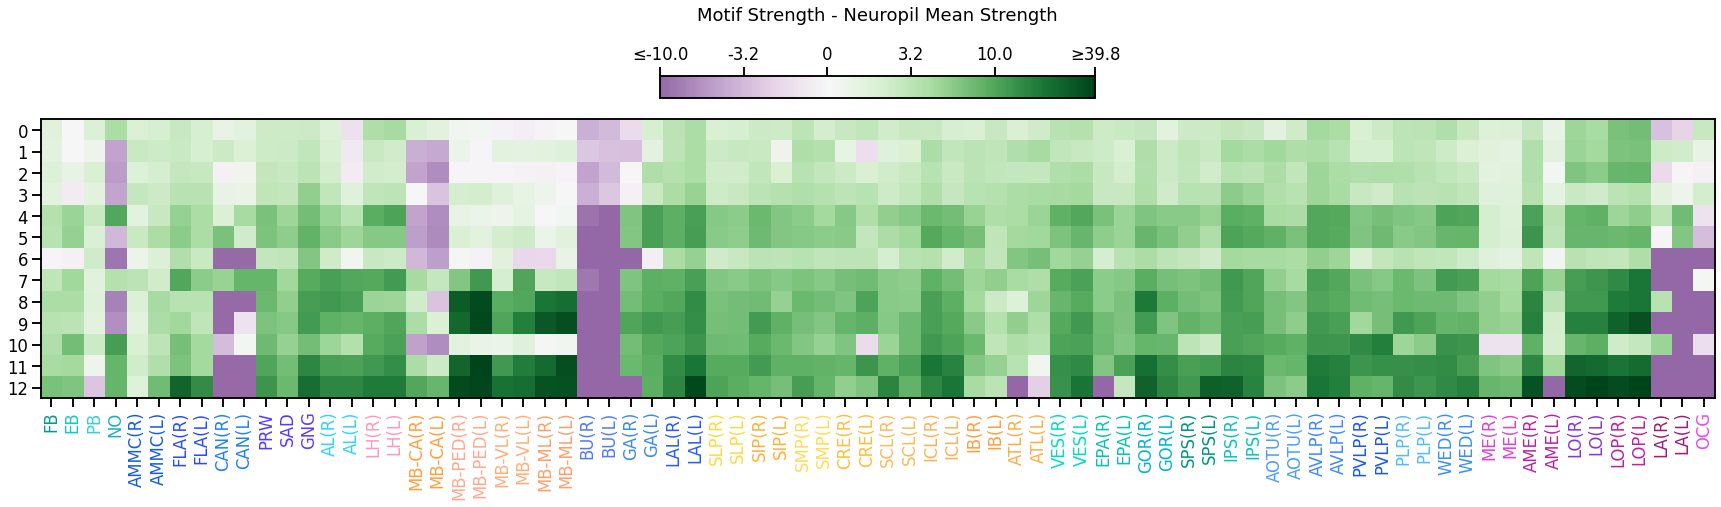

In [591]:
# visualize single rule matrix
fig, ax = plt.subplots(1, 1, figsize=(30,8))
norm = MidpointNormalize(vmin=-1, vmax=1.6, midpoint=0)
# rule_map = ax.imshow(rel_er_feq, cmap='Reds')
rule_map = ax.imshow(my_log(rel_er_feq - np_strength), cmap='PRGn', norm=norm)
ax.set_xticks(range(78))
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.set_xticklabels(np.array(np_names)[available_mask], rotation = 90)
for xtick, color in zip(ax.get_xticklabels(), np.array(np_color)[available_mask]):
    xtick.set_color(color)
ax.set_yticks(range(13))

cbar = plt.colorbar(rule_map, ax=ax, label="Motif Strength - Neuropil Mean Strength\n",
             fraction=0.05, orientation='horizontal', location='top',
             ticks=[-1,-0.5,0,0.5,1,1.7])
cbar.ax.set_xticklabels(['≤-10.0', "-3.2", "0", "3.2", "10.0", "≥39.8"])
# plt.show()
plt.savefig('figures/stats-{}/tri-strength-np-rel-np-mean.pdf'.format(ver), bbox_inches='tight')

In [595]:
my_log(rel_er_feq - rel_er_feq.mean(0)).min()

16.493111263375848

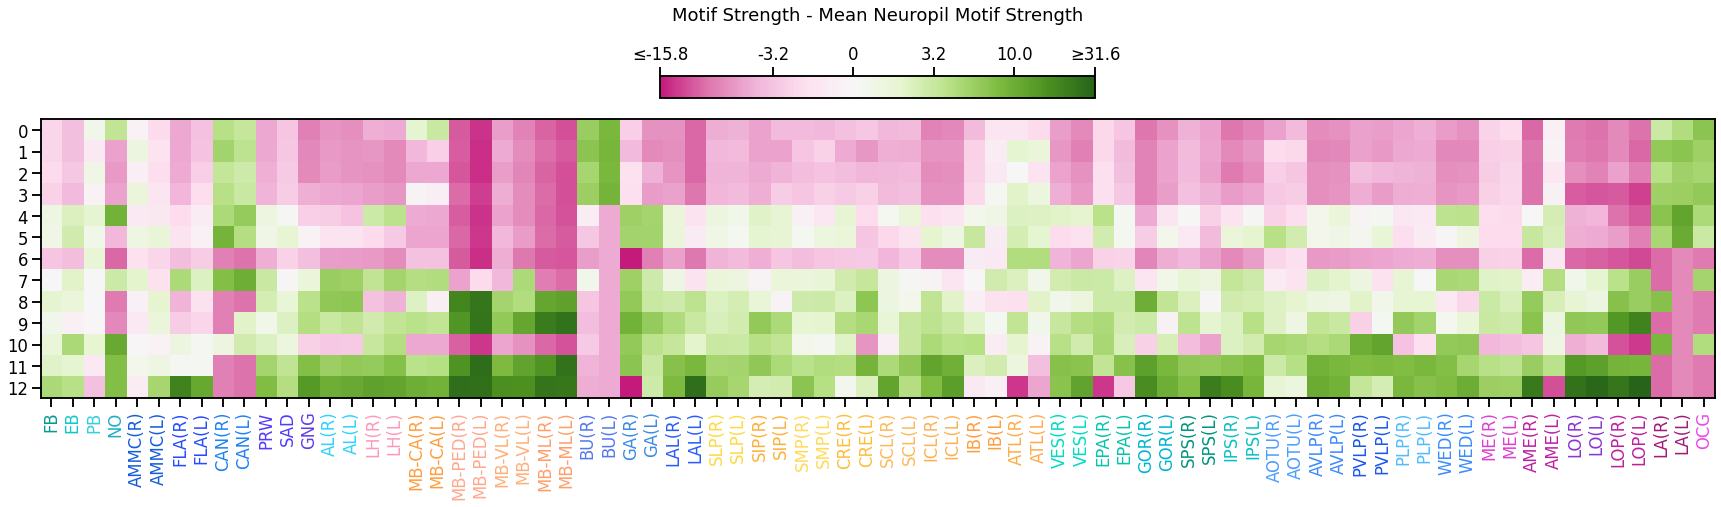

In [597]:
# visualize single rule matrix
fig, ax = plt.subplots(1, 1, figsize=(30,8))
norm = MidpointNormalize(vmin=-1.2, vmax=1.5, midpoint=0)
# rule_map = ax.imshow(rel_er_feq, cmap='Reds')
rule_map = ax.imshow(my_log(rel_er_feq - rel_er_feq.mean(0)), cmap='PiYG', norm=norm)
ax.set_xticks(range(78))
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.set_xticklabels(np.array(np_names)[available_mask], rotation = 90)
for xtick, color in zip(ax.get_xticklabels(), np.array(np_color)[available_mask]):
    xtick.set_color(color)
ax.set_yticks(range(13))

cbar = plt.colorbar(rule_map, ax=ax, label="Motif Strength - Mean Neuropil Motif Strength\n",
             fraction=0.05, orientation='horizontal', location='top',
             ticks=[-1.2,-0.5,0,0.5,1,1.5])
cbar.ax.set_xticklabels(['≤-15.8', "-3.2", "0", "3.2", "10.0", "≥31.6"])
# plt.show()
plt.savefig('figures/stats-{}/tri-strength-np-rel-motif-mean.pdf'.format(ver), bbox_inches='tight')

### Whole-net motif strength

In [494]:
import pickle

motif_strength_mean_agg = {}
motif_strength_std_agg = {}

if os.path.exists('saved/neuropil-motifs-strength-630/whole-v630-motif-strength-mean.pickle'):
    with open('saved/neuropil-motifs-strength-630/whole-v630-motif-strength-mean.pickle', 'rb') as handle:
        motif_strength_dict = pickle.load(handle)
        motif_strength_mean_agg["whole"] = motif_strength_dict
        
if os.path.exists('saved/neuropil-motifs-strength-630/whole-v630-motif-strength-std.pickle'):
    with open('saved/neuropil-motifs-strength-630/whole-v630-motif-strength-std.pickle', 'rb') as handle:
        motif_strength_dict = pickle.load(handle)
        motif_strength_std_agg["whole"] = motif_strength_dict
        
with open('saved/neuropil-motifs-630/whole-v630-motif.pickle', 'rb') as handle:
    whole_motif_profile = pickle.load(handle)

In [495]:
edge_mutiplication = np.array([2,2,2,3,3,3,3,4,4,4,4,5,6])

In [496]:
whole_strength_mean = np.array([motifdict2list(motif_strength_mean_agg['whole'])]).T[match_order].reshape(-1)
whole_strength_mean

array([14.2986927 , 14.66709995, 14.71470833, 15.46768856, 15.32584953,
       16.25233459, 15.28436852, 18.87763977, 20.30069733, 19.95704842,
       16.32028389, 23.04451561, 23.42650414])

In [497]:
whole_strength_std = np.array([motifdict2list(motif_strength_std_agg['whole'])]).T[match_order].reshape(-1)
whole_strength_std

array([ 4.71329308,  4.9521246 ,  4.81144476,  5.86359406, 14.37221241,
       17.25272369,  5.65176582, 23.16642189, 25.06478882, 27.30038452,
       10.47654247, 30.95796776, 22.55234337])

In [504]:
whole_strength_error = 1.96*whole_strength_std / np.sqrt(edge_mutiplication * whole_motif_profile['whole'][1])
whole_strength_error

array([0.0007045 , 0.0006339 , 0.00058482, 0.0033334 , 0.00244018,
       0.00321234, 0.01207448, 0.02657955, 0.02956731, 0.00524469,
       0.0138216 , 0.036175  , 0.0431552 ])

In [558]:
g_mean_stength = gt.edge_average(g, g.ep["syn_count"])[0]

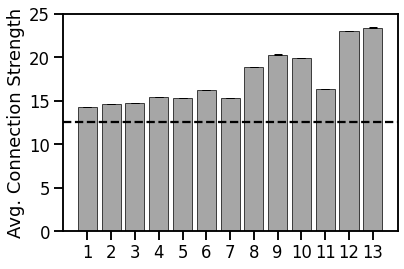

In [598]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
cmap = plt.cm.get_cmap('PiYG') 
# normalize = plt.Normalize(vmin=min(whole_strength_mean), vmax=max(whole_strength_mean))
# colors = [cmap(normalize(value)) for value in whole_strength_mean]
ax.bar(range(1, 14), whole_strength_mean, yerr=whole_strength_error, capsize=4, color='gray', 
       edgecolor='black', linewidth=1, alpha=0.7)
plt.axhline(g_mean_stength, color='k', linestyle='--')
ax.set_xticks(range(1,14))
ax.set_ylim([0,25])
ax.set_ylabel('Avg. Connection Strength')
plt.savefig('figures/stats-{}/tri-strength-whole.pdf'.format(ver), bbox_inches='tight')